# **AI for Biology: Building a Language Model on Biological Sequences** 🔬

<img src="https://render.fineartamerica.com/images/rendered/default/print/8/5.5/break/images/artworkimages/medium/2/antibodies-in-action-david-goodsellscience-photo-library.jpg" width="[8](https://)0%"/>

© MenaML 2026. Apache License 2.0.

**Authors**: Natasha Latysheva

**Topics**: Biology, Proteins, Large Language Models, Embeddings

**Level**: Beginner-Intermediate

**Aims/Learning Objectives:**

1. Learn the basics of proteins (e.g. what is a protein, what is it made of?) 🧪
2. Learn a general set of tool for working with proteins:
    1. How to use Pretrained LM Transformer from HuggingFace 🤗
    2. Exploring and working with embeddings 🔍
    3. How to leverage the Pretrained LM  and leverage them for specific tasks 🤔
3. Apply your knowledge to train your own machine learning model that predicts protein function 🚀

**Prerequisites:**

- Basic ML knowledge and Python
- No biology knowledge required

**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

**Acknowledgements**

This tutorial was adapted from Chapter 2 of the recently-published book "Deep Learning for Biology" by Charles Ravarani and Natasha Latysheva. If you are interested in this type of content, please check out the book! :)

<img src="https://i.ibb.co/C5m5rSy2/81nt-WZvo-KTL-SL1500-1.jpg" alt="81nt-WZvo-KTL-SL1500-1" border="0" width="30%" />

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)
%%capture
!pip install -qU py3Dmol
!pip install transformers datasets
!pip install obonet
!pip install biopython

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Bio

import tensorflow as tf
import flax.linen as nn
import optax
import tensorflow_datasets as tfds

In [ ]:
# @title Check TPU/GPU. (Run Cell)
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")

Found 1 JAX devices of type Tesla T4.


# 1. **What is a protein?**

It's no exaggeration to say that life as we know it runs on **proteins**. The human genome encodes around 20,000 different proteins, each made from genes written in DNA. Some have simple, well-understood functions—like **collagen**, which provides structural support and elasticity to tissues, or **haemoglobin**, which transports oxygen and carbon dioxide between the lungs and the rest of the body. Others have slightly more abstract roles: they act as messengers, modulators, or signal carriers, transmitting information within and between cells. For example, **insulin** is a protein hormone that signals cells to absorb sugar from the bloodstream.

We'll dive into how DNA and proteins work in more detail soon. But for now, imagine a protein as a blobby molecular machine bumping around in the crowded cell environment, occasionally making productive collisions. Its shape and movement may seem chaotic, but both have been fine-tuned by millions of years of evolution to carry out very specific molecular functions. The particular details of its blobby structure have been honed by millions of years of evolution in a way that allows it to perform its molecular function.

One key detail for this tutorial: a protein can be represented as a sequence of its building blocks, called _amino acids_. Just as English uses 26 letters to form words, proteins use an alphabet of 21 amino acids to form long chains with specific shapes and jobs.

## Goal of this tutorial

With that in mind, the goal of this tutorial is simple: we'll train a model to predict a protein's function given its amino acid sequence. For example:

- Given the sequence of the COL1A1 collagen protein (`MFSFVDLR`...), we might predict its function is likely `structural` with probability 0.7, `enzymatic` with probability 0.01, and so on.
- Given the sequence of the INS insulin protein (`MALWMRLL`...), we might predict its function is likely `metabolic` with probability 0.6, `signaling` with probability 0.3, and so on.




## Biology Primer

A protein’s function is closely tied to its 3D structure, which in turn is determined by its primary amino acid sequence.

To recap the flow of information: a **gene** encodes the amino acid sequence of a protein. That sequence determines the protein's structure, and the structure governs its function. Ultimately, these amino acid sequences are encoded by the DNA in an organism’s genome—refined over billions of years of evolution.



### Protein Structure

Protein structure is typically described in four hierarchical levels:

- _Primary structure_: The linear sequence of amino acids
- _Secondary structure_: Local folding into structural elements such as alpha helices and beta sheets
- _Tertiary structure_: The overall 3D shape formed by the complete amino acid chain
- _Quaternary structure_: The assembly of multiple protein subunits into a functional complex (not all proteins have this)

As an example, here is the hierarchical structure of hemoglobin:

<a href="https://ibb.co/ynNK7CXh"><img src="https://i.ibb.co/Z6fv7rVH/protein-structure-wikipedia.png" alt="protein-structure-wikipedia" border="0" width="40%"></a>

The human genetic code specifies 20 standard amino acids. Each has a unique chemical structure, but they can be grouped by shared biochemical properties—such as hydrophobicity (how they interact with water), charge (positive, negative, or neutral), and polarity (how evenly electrical charge is distributed over the molecule).

Although biochemistry students are often expected to memorize all 20 amino acids, complete with names, structures, and single-letter codes (don’t ask us how we know), it’s more practical here to focus on their functional roles:

<a href="https://ibb.co/W4jCSW48"><img src="https://i.ibb.co/Hf3ZmDfw/amino-acids-cropped.png" alt="amino-acids-cropped" border="0" width="80%"></a>

For instance, `D` (aspartic acid) and `E` (glutamic acid) are both negatively charged and often interchangeable without drastically altering a protein’s function. But other amino acids play much more specific roles, and even a single substitution can dramatically alter how a protein folds or functions—sometimes with serious effects. In fact, many genetic diseases are caused by such point mutations. One famous example is sickle cell anemia, which is caused by a single-letter change in the gene for hemoglobin that replaces a hydrophilic amino acid (`E`) with a hydrophobic one (`V`), leading to misshapen red blood cells.

With that introduction to protein structure, let’s now look at function—what proteins actually do in the cell.




### Protein Function

Proteins carry out nearly every task required for life: they catalyze chemical reactions, transmit signals, transport molecules, provide structural support, and regulate gene expression. Because of this diversity, systematically cataloguing protein functions is a massive undertaking—and one of the most widely used frameworks for doing so is the **Gene Ontology** (GO) project.

The GO system organizes protein function into three broad categories, each capturing a different aspect of how proteins behave in the cell:

* _Biological process_: This describes the broader biological programs the protein contributes to—like cell division, response to stress, carbohydrate metabolism, or immune signaling.
* _Molecular function_: This describes the specific biochemical activity of the protein itself—such as binding to DNA or ATP (a molecule that stores and transfers energy in cells), acting as a kinase (an enzyme that attaches a small chemical tag called a phosphate group to other molecules to change their activity), or transporting ions across membranes.
* _Cellular component_: This indicates where in the cell the protein usually resides—like the nucleus, mitochondria, or extracellular space. Although it’s technically a location label and not a function _per se_, it often provides important clues about the protein’s role (e.g., proteins in the mitochondria are probably involved in energy production).

Each protein can have multiple GO annotations across these categories. For example, a single protein might bind ATP (molecular function), drive muscle contraction (biological process), and localize to muscle fibers (cellular component). Some annotations are derived from direct experimental assays, while others are inferred computationally through similarity to known proteins. In this tutorial, we’ll work with a curated subset of high-confidence, experimentally validated GO annotations.

### Predicting Protein Function

***Why predict a protein’s function from its sequence?*** This is one of the most fundamental challenges in modern biology. Below are a few of the most common and impactful applications:

- _Biotechnology and protein engineering_: If we can reliably predict function from sequence, we can begin to design new proteins with desired properties. This could be useful for designing enzymes for industrial chemistry, therapeutic proteins for medicine, or synthetic biology tools.
- _Understanding disease mechanisms_: Many diseases are caused by specific sequence changes (variants, or mutations) that disrupt protein function. A good predictive model can help identify how specific mutations alter function, offering insights into disease mechanisms and potential therapeutic targets.
- _Genome annotation_: As we continue sequencing the genomes of new species, we're uncovering vast numbers of proteins whose functions remain unknown. For newly identified proteins—especially those that are distantly evolutionarily related to any known ones—computational prediction is essential for assigning functional hypotheses.
- _Metagenomics and microbiome analysis_: When sequencing entire microbial communities, such as gut bacteria or ocean microbiota, many protein-coding genes have no close matches in existing databases. Predicting function from sequence helps uncover the roles of these unknown proteins, advancing our understanding of microbial ecosystems and their effects on hosts or the environment.

```{note}
Although the task may sound somewhat straightforward—input a sequence, output a function—accurate protein function prediction is an extremely challenging problem. To succeed, a model must implicitly understand a range of highly complex biological principles: how amino acid sequence determines 3D structure (a Nobel Prize–winning machine learning problem in its own right), how structure enables function, and how these functions operate in the dynamic, crowded environment of the cell.
```

In this tutorial, we won’t aim for state-of-the-art performance. Instead, our goal is to build a simple working model and develop intuition for how protein sequences can be mapped to functional annotations. Along the way, we’ll introduce several useful machine learning techniques—including using pre-trained models to extract embeddings, visualizing those embeddings, and training lightweight classifiers on top of them—that you can use again and again in other projects.




## Machine Learning Primer

We’ve briefly reviewed the biological background of proteins and how their function is encoded. Now, we’ll turn to the machine learning techniques that allow us to learn from protein sequences in practice.

### Large Language Models

It’s hard these days to go anywhere without bumping into _large language models_ (LLMs). Many recent breakthrough models in AI—such as ChatGPT, Gemini, Claude, and Llama—fall under this category. While these models involve immense engineering, the fundamental idea behind them is surprisingly simple: they’re trained to predict the next token (i.e. a word or character) given the preceding context. There are slight variations—such as _masked language models_, which hide random tokens during training to encourage contextual reasoning—but the core principle remains the same.

One of the most surprising discoveries in modern AI has been that if you train a large enough model (in terms of number of parameters) on enough data (in terms of total tokens), remarkable capabilities emerge without explicit supervision. These models can suddenly summarize text, translate between languages, and even generate creative writing like poems and stories—despite never being trained directly to do so.

This holds promise for biology. In many ways, biology is language-like: DNA and proteins are sequences built from discrete alphabets, with complex patterns and context-dependent "grammar." By training LLMs on massive corpora of biological sequences—using the same next-token prediction objective—we can learn rich representations of biological information.

These learned representations can then be used for a wide range of downstream tasks, such as predicting a protein’s function, inferring the effects of mutations, or identifying structural properties—all without needing to retrain a new model from scratch.

In this tutorial, we’ll explore one of the most successful protein language models to date: **ESM2**.



### Embeddings

One of the most powerful and versatile outputs of language models is their ability to generate **embeddings**. An embedding is a numerical vector—a list of floating point numbers—that encodes the meaning or structure of an entity like a word, sentence, or protein sequence. For example, a protein might be represented by an embedding like `[0.1, -0.3, 1.3, 0.9, 0.2]`, which could capture aspects of its biochemical or structural properties in a compact numerical form.

Embeddings from language models are not just arbitrary numbers—they are structured so that similar inputs result in similar embeddings. Related words like `lion`, `tiger`, and `panther` cluster together in a "semantic space". Likewise, protein sequences with similar structure or function—such as collagen I and collagen II—will tend to have embeddings that are close together in what we might call a "protein space".

This idea generalizes to the concept of a _latent space_—a continuous, abstract space where similar entities are positioned close together based on learned patterns. In such spaces, we can perform powerful operations like interpolation, clustering, and generative design. For proteins, latent spaces can capture relationships between sequences that don’t necessarily align well but nonetheless encode similar properties. Two proteins with different sequences may still map to nearby points in embedding space, suggesting shared ancestry or convergent function. These representations can also help predict new functions for uncharacterized proteins by comparing them to annotated neighbors in the space.

```{note}
To identify proteins with similar structure or function, you can compare their embeddings using _cosine similarity_—a measure of how aligned two vectors are, regardless of their magnitude. This works even when sequences differ significantly at the amino acid level. By computing cosine similarities between a query protein and a set of known proteins, you can rank the closest matches in embedding space. These top hits often share functional roles, structural features, or evolutionary history.
```



### Pretraining and Fine-tuning

Many machine learning tasks share underlying structure. Whether your goal is detecting hate speech, answering law school entrance questions, or writing poems about capybaras, your model first needs a strong foundation in how language works. Rather than training from scratch for every task, we typically start from a general-purpose model that’s been _pretrained_ on a huge, diverse dataset.

Pretraining gives a model broad knowledge and general capabilities. For a specific application, we often follow it with a smaller, focused training step called _fine-tuning_—where the model is trained further on a domain-specific dataset. This two-stage process is now standard in many areas of machine learning, especially as pretrained language models have become increasingly powerful.

Here, we’ll take a slightly different approach. Rather than fine-tuning the entire pretrained model, we’ll treat it as a frozen feature extractor: we’ll use its embeddings as input to a smaller classifier that we’ll train from scratch. This strategy is efficient, requires little data, and still leverages the rich representations learned by the pretrained model.




## Representations of Proteins and Protein LMs

Previously, we discussed what proteins are and how their structure is organized hierarchically—from a linear chain of amino acids, to local folding, to the final 3D form that enables their function. To make this less abstract, let’s load up and visualize an example protein structure using the `py3Dmol` library:


In [ ]:
import py3Dmol
import requests


def fetch_protein_structure(pdb_id: str) -> str:
  """Grab a PDB protein structure from the RCSB Protein Data Bank."""
  url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
  response = requests.get(url)
  return response.text


# The Protein Data Bank (PDB) is the main database of protein structures.
# Each structure has a unique 4-character PDB ID. Below are a few examples.
protein_to_pdb = {
  "insulin": "3I40",  # Human insulin – regulates glucose uptake.
  "collagen": "1BKV",  # Human collagen – provides structural support.
  "proteasome": "1YAR",  # Archaebacterial proteasome – degrades proteins.
}

protein = "collagen"  # @param ["insulin", "collagen", "proteasome"]
pdb_structure = fetch_protein_structure(pdb_id=protein_to_pdb[protein])

pdbview = py3Dmol.view(width=400, height=300)
pdbview.addModel(pdb_structure, "pdb")
pdbview.setStyle({"cartoon": {"color": "spectrum"}})
pdbview.zoomTo()
pdbview.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

This will  display an interactive 3D rendering of your chosen protein. Try viewing the other examples like `insulin` and `proteasome` to appreciate the incredible structural diversity of proteins. Their shapes often reflect their specialized roles—for example, the long, springy structure of collagen relates to its function as a flexible, supportive scaffold found throughout many tissues in the body.



### Numerical Representation of a Protein

While 3D visualizations are useful for exploration, machine learning models require numerical input. To analyze or model proteins with machine learning techniques, we typically start from their 1D amino acid sequence.

Protein sequences for most known organisms can be retrieved from public databases such as [Uniprot](https://www.uniprot.org/). For example, here’s the amino acid sequence of human insulin ([source](https://www.uniprot.org/uniprotkb/P01308/entry#sequences)):

In [ ]:
# Precursor insulin protein sequence (processed into two protein chains).
insulin_sequence = (
  "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
  "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
)
print(f"Length of the insulin protein precursor: {len(insulin_sequence)}.")

Length of the insulin protein precursor: 110.


This sequence representation is easy to store and manipulate, but it still needs to be converted to a numerical format before it can be used by machine learning models.



### One-Hot Encoding of a Protein Sequence

The simplest way to convert a protein sequence into numerical form is with _one-hot encoding_. Here’s how it works:

- There are 20 standard amino acids.
- Each amino acid is represented by a binary vector of length 20, where only one position is `1` (indicating the identity of that amino acid), and all other positions are `0`.
- A protein sequence is then converted into a sequence of these one-hot vectors—one for each amino acid.

Let’s walk through a toy example: encoding the short protein `MALWN` (the first 5 amino acids of the insulin precursor protein).

First, let's define the mapping between an amino acid letter code and an integer index:

In [ ]:
amino_acids = [
  "R", "H", "K", "D", "E", "S", "T", "N", "Q", "G", "P", "C", "A", "V", "I",
  "L", "M", "F", "Y", "W",
]

amino_acid_to_index = {
  amino_acid: index for index, amino_acid in enumerate(amino_acids)
}

print(amino_acid_to_index)

{'R': 0, 'H': 1, 'K': 2, 'D': 3, 'E': 4, 'S': 5, 'T': 6, 'N': 7, 'Q': 8, 'G': 9, 'P': 10, 'C': 11, 'A': 12, 'V': 13, 'I': 14, 'L': 15, 'M': 16, 'F': 17, 'Y': 18, 'W': 19}


Given a protein sequence, we can convert it to a sequence of integers:


In [ ]:
# Methionine, alanine, leucine, tryptophan, methionine.
tiny_protein = ["M", "A", "L", "W", "M"]

tiny_protein_indices = [
  amino_acid_to_index[amino_acid] for amino_acid in tiny_protein
]

tiny_protein_indices

[16, 12, 15, 19, 16]


And given a sequence of integers, we can convert it into a one-hot encoding:

<a href="https://ibb.co/219p0C8t"><img src="https://i.ibb.co/393P5jfN/protein-one-hot-encoding.png" alt="protein-one-hot-encoding" border="0"></a>


In this image, we see that:

- The resulting matrix has the shape `[5, 20]`, where each of the 5 rows corresponds to one amino acid in the sequence, and each column represents one of the 20 standard amino acids.
- Each row contains all zeroes except for a single 1 in the position corresponding to that amino acid’s identity, preserving its categorical nature without implying any numerical ordering or similarity.


```{note}
Why not just skip the one hot encoding step, and use amino acid indices directly?

The issue is that numeric indices (like `3` vs `17`) imply an artificial order and relative similarity, even though amino acids are categorical entities without meaningful numerical relationships.

One-hot encoding avoids this by assigning each amino acid a distinct binary vector—ensuring the model treats them as equally separate and avoids inferring non-existent patterns from arbitrary index values.
```

In code, we can use the handy `jax.nn.one_hot` utility from the JAX library to compute a one-hot encoding given indices:


In [ ]:
import jax

one_hot_encoded_sequence = jax.nn.one_hot(
  x=tiny_protein_indices, num_classes=len(amino_acids)
)

print(one_hot_encoded_sequence)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


We can visualize the resulting one-hot encoding matrix as a heatmap (essentially recreating the earlier figure):

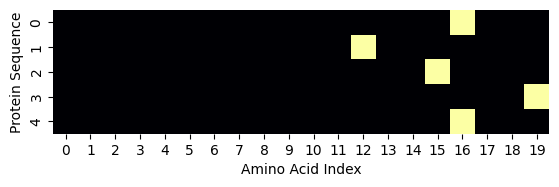

In [ ]:
import seaborn as sns

fig = sns.heatmap(
  one_hot_encoded_sequence, square=True, cbar=False, cmap="inferno"
)
fig.set(xlabel="Amino Acid Index", ylabel="Protein Sequence");


Now that we’ve constructed a basic numerical representation of a protein, we’re ready to move beyond this simplistic format and explore _learned embeddings_—dense vector representations that encode much more biological meaning about each amino acid.



### Learned Embeddings of Amino Acids

Throughout the rest of this tutorial, we’ll use a series of pretrained protein language models called [ESM2](https://www.science.org/doi/10.1126/science.ade2574), released by [Meta](https://about.meta.com/) in 2023 (ESM stands for _evolutionary scale modeling_). These models are hosted on the [Hugging Face](https://huggingface.co/) platform. If you haven’t encountered it yet, Hugging Face is a fantastic resource with [thousands of pretrained models](https://huggingface.co/models) ready for you to use and explore.

We’ll explore how the ESM2 model works in more detail shortly, but first let’s examine how it represents individual amino acids. We’ll access the model using the Hugging Face `transformers` library—ESM2 is based on the _transformer_ neural network architecture [introduced in 2017](https://arxiv.org/abs/1706.03762), which has become the standard for modeling sequences like text and proteins.

In [ ]:
from transformers import AutoTokenizer, EsmModel

# Model checkpoint name taken from this GitHub README:
# https://github.com/facebookresearch/esm#available-models-and-datasets-
model_checkpoint = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can check the model’s token-to-index mapping:

In [ ]:
vocab_to_index = tokenizer.get_vocab()
print(vocab_to_index)

{'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}



This is similar to the manual amino acid indexing we did earlier, but includes special tokens like `<unk>` for unknown residues, `<eos>` for end-of-sequence, and rare amino acids like `U` (selenocysteine) and `O` (pyrrolysine).

Let's use the ESM2 tokenizer to encode our tiny protein sequence:


In [ ]:
tokenized_tiny_protein = tokenizer("MALWM")["input_ids"]
tokenized_tiny_protein

[0, 20, 5, 4, 22, 20, 2]

If desired, we can drop the special start (`<cls>`) and end (`<eos>`) tokens:


In [ ]:
tokenized_tiny_protein[1:-1]

[20, 5, 4, 22, 20]

Now we’ll extract the learned token embeddings from the model using `model.get_input_embeddings()`:

In [ ]:
token_embeddings = model.get_input_embeddings().weight.detach().numpy()
token_embeddings.shape

(33, 1280)

Each of the 33 possible tokens is embedded into a 1280-dimensional space. While humans can’t visualize such high-dimensional spaces directly, we can apply dimensionality reduction techniques like t-SNE or UMAP to project the embeddings down to two dimensions. This allows us to inspect how the model organizes different tokens in a more interpretable form:


In [ ]:
import pandas as pd
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(token_embeddings)
embeddings_tsne_df = pd.DataFrame(
  embeddings_tsne, columns=["first_dim", "second_dim"]
)
embeddings_tsne_df.shape

(33, 2)

We can see that the t-SNE-transformed array has shape `(33, 2)`, meaning that each of the 33 tokens has been projected into a two-dimensional space. The plot below shows a scatter plot of these points, giving us a visual sense of how the model organizes token embeddings:


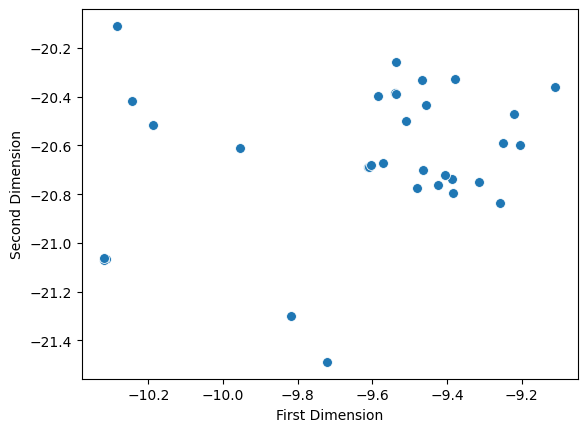

In [ ]:
fig = sns.scatterplot(
  data=embeddings_tsne_df, x="first_dim", y="second_dim", s=50
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension");

Even without labels, clusters begin to emerge, hinting that the model has learned to organize tokens in a meaningful way. To sanity check whether biochemically similar tokens cluster in the 2D embedding space, we can label each token using known amino acid properties (like those shown earlier in this tutorial) and replot the t-SNE projection below:


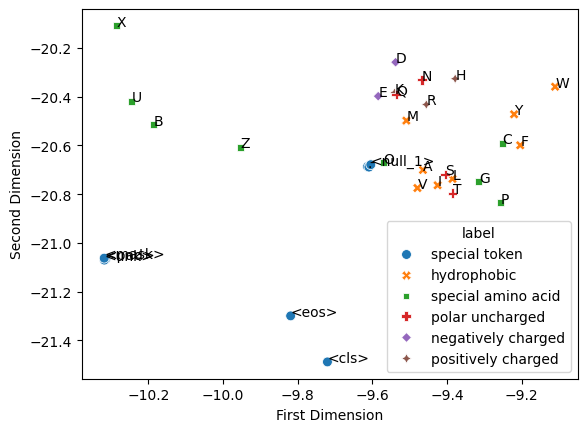

In [ ]:
embeddings_tsne_df["token"] = list(vocab_to_index.keys())

token_annotation = {
  "hydrophobic": ["A", "F", "I", "L", "M", "V", "W", "Y"],
  "polar uncharged": ["N", "Q", "S", "T"],
  "negatively charged": ["D", "E"],
  "positively charged": ["H", "K", "R"],
  "special amino acid": ["B", "C", "G", "O", "P", "U", "X", "Z"],
  "special token": [
    "-",
    ".",
    "<cls>",
    "<eos>",
    "<mask>",
    "<null_1>",
    "<pad>",
    "<unk>",
  ],
}

embeddings_tsne_df["label"] = embeddings_tsne_df["token"].map(
  {t: label for label, tokens in token_annotation.items() for t in tokens}
)

fig = sns.scatterplot(
  data=embeddings_tsne_df,
  x="first_dim",
  y="second_dim",
  hue="label",
  style="label",
  s=50,
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension")
texts = [
  fig.text(point["first_dim"], point["second_dim"], point["token"])
  for _, point in embeddings_tsne_df.iterrows()
]


Tokens with similar biochemical properties tend to cluster together. For instance, hydrophobic amino acids like `F`, `Y`, and `W` group in the upper right, while special-purpose tokens such as `<cls>` and `<eos>` appear together on the left side of the plot. This structure suggests that the model has learned meaningful distinctions among amino acids based on the roles they play within protein sequences.

Now that we’ve explored what these token embeddings look like, let’s dive into how the ESM2 model actually works—and how it learns such representations in the first place.


### The ESM2 Protein Language Model

Now that you’re more familiar with token embeddings, let’s discuss how the ESM2 model actually works. ESM2 is a _masked language model_ (MLM), which means it was trained by repeatedly masking a random subset of amino acids in each protein sequence and asking the model to predict them. In the case of ESM2, 15% of the amino acids in each sequence were masked during training. The diagram below illustrates this visually, comparing it to masked language modeling in natural language tasks.


<a href="https://ibb.co/0jHycBLz"><img src="https://i.ibb.co/7JstXgD0/language-model-training.png" alt="language-model-training" border="0" width=80%></a>


In natural language, models are trained to predict missing words (or sometimes sub-words) from surrounding context. Protein language models use the same principle: randomly masking amino acids in a sequence and training the model to predict them from the surrounding context.

Let’s try masking one amino acid in the insulin protein sequence and see whether the model can predict it:


In [ ]:
insulin_sequence = (
  "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
  "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
)

masked_insulin_sequence = (
  # Let's mask the `L` amino acid in the 29th position (0-based indexing):
  #       ...LALLALWGPDPAAAFVNQH  L   CGSHLVEALYLVCGERGFF...
  "MALWMRLLPLLALLALWGPDPAAAFVNQH<mask>CGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
  "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
)

# Tokenize the masked insulin sequence.
masked_inputs = tokenizer(masked_insulin_sequence)["input_ids"]

# Check that we indeed have a <mask> token in the place that we expect it. Note
# that the tokenizer adds a <cls> token to the start of the sequence, so we in
# fact expect the <mask> token at position 30 (not 29).
assert masked_inputs[30] == vocab_to_index["<mask>"]


The `<mask>` token tells the model to predict the amino acid at that position. To do this, we load the full language model, `EsmForMaskedLM`, which includes the language prediction head.

```{note}
To make inference faster, we’ll use a smaller ESM2 model variant (150M parameters with 640-dimensional embeddings) rather than the large 650M model with 1280-dimensional embeddings used earlier. This is a good reminder that many model on Hugging Face come in different sizes, and swapping between them is often as simple as changing a model checkpoint.

Of course, there’s a tradeoff—smaller models may capture less information and typically perform worse on complex tasks. Still, they’re great for rapid prototyping and exploring model behavior.
```

We load up the model:

In [ ]:
from transformers import EsmForMaskedLM

# Model checkpoint name taken from this GitHub README:
# https://github.com/facebookresearch/esm#available-models-and-datasets-
model_checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
masked_lm_model = EsmForMaskedLM.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

And run it to get predictions for the masked token. We see that the model correctly predicts the token `L` (Leucine) with very high probability:


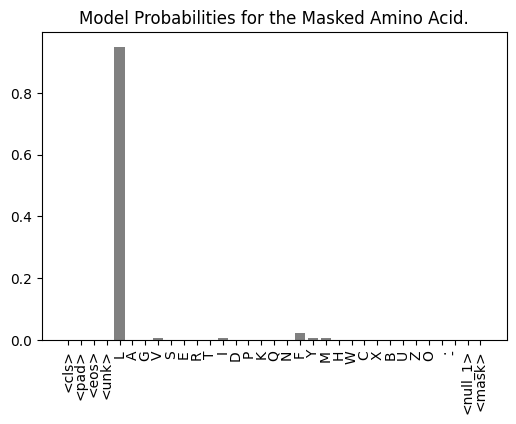

In [ ]:
import matplotlib.pyplot as plt

model_outputs = masked_lm_model(
  **tokenizer(text=masked_insulin_sequence, return_tensors="pt")
)
model_preds = model_outputs.logits

# Index into the predictions at the <mask> position.
mask_preds = model_preds[0, 30].detach().numpy()

# Apply softmax to convert the model's predicted logits to probabilities.
mask_probs = jax.nn.softmax(mask_preds)

# Visualize the predicted probability of each token.
letters = list(vocab_to_index.keys())
fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(letters, mask_probs, color="grey")
plt.xticks(rotation=90)
plt.title("Model Probabilities for the Masked Amino Acid.");

Let's rewrite this code in a more general form as `MaskPredictor`, with methods that mask sequence, predict and plot the predictions:

In [ ]:
from matplotlib.figure import Figure
from transformers import PreTrainedModel, PreTrainedTokenizer

class MaskPredictor:
  """Predict masked amino acids using a protein language model."""

  def __init__(self, tokenizer: PreTrainedTokenizer, model: PreTrainedModel):
    """Initialize with a tokenizer and pretrained model."""
    self.tokenizer = tokenizer
    self.model = model

  def plot_predictions(self, sequence: str, mask_index: int) -> Figure:
    """Plot predicted probabilities for the masked amino acid."""
    mask_probs = self.predict(sequence, mask_index)
    fig, _ = plt.subplots(figsize=(6, 4))
    plt.bar(list(self.tokenizer.get_vocab().keys()), mask_probs, color="grey")
    plt.xticks(rotation=90)
    plt.title(
      "Model Probabilities for the Masked Amino Acid\n"
      f"at Index={mask_index} (True Amino Acid = {sequence[mask_index]})."
    )
    return fig

  def predict(self, sequence: str, mask_index: int) -> jax.Array:
    """Return model probabilities for masked amino acid at a position."""
    masked_sequence = self.mask_sequence(sequence, mask_index)
    masked_inputs = self.tokenizer(masked_sequence, return_tensors="pt")
    model_outputs = self.model(**masked_inputs)
    mask_preds = model_outputs.logits[0, mask_index + 1].detach().numpy()
    mask_probs = jax.nn.softmax(mask_preds)
    return mask_probs

  @staticmethod
  def mask_sequence(sequence: str, mask_index: int) -> str:
    """Insert mask token at specified index in the input sequence."""
    if mask_index < 0 or mask_index > len(sequence):
      raise ValueError("Mask index outside of sequence range.")
    return f"{sequence[0:mask_index]}<mask>{sequence[(mask_index + 1):]}"

Let’s try it on a different position—index 26, where the correct amino acid is `N` (asparagine):

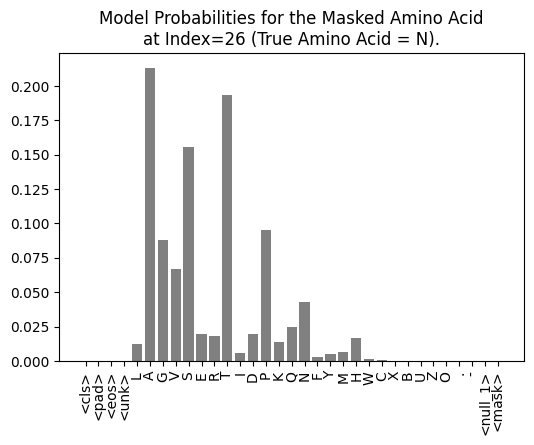

In [ ]:
MaskPredictor(tokenizer, model=masked_lm_model).plot_predictions(
  sequence=insulin_sequence, mask_index=26
);


In this case, the model doesn’t strongly prefer any one amino acid. It assigns moderate probability to several, including `A`, `T`, and `S` (with the model assigning the true amino acid `N` a fairly low probability). This uncertainty could reflect the biochemical flexibility of that position—some regions of proteins can tolerate different residues due to redundancy, structural flexibility, or lack of strict functional constraints. These are often called “permissive” positions and are common in disordered (unstructured) or surface regions of proteins.

This example illustrates that the model has learned understands the probabilistic grammar of proteins. The next question is: ***how can we leverage this understanding to represent an entire protein, not just one amino acid at a time?***



### Strategies for Extracting an Embedding for an Entire Protein

So far, we’ve explored how the ESM2 model represents individual amino acids. But many downstream tasks—like predicting protein function—require a fixed-length representation for the entire protein sequence. How can we convert a variable-length sequence of amino acids into a single embedding vector that captures the protein’s overall structure and meaning?

Several strategies are commonly used:

- _Concatenation of amino acid embeddings_: One simple approach is to loop through each amino acid in a sequence, extract its embedding, and concatenate them into one long vector. For example, if a protein has length 10 and each amino acid has a 640-dimensional embedding, this yields a protein embedding of length `10 × 640 = 6400`. While this preserves fine-grained information of each amino acid, it has several drawbacks:
  - _Variable length_: Different proteins will yield different-length embeddings, which complicates model input formatting.
  - _Scalability_: Long proteins produce huge embeddings. For example, titin—the longest known human protein at ~34,000 amino acids—would produce an embedding with over *43 million* values. That’s unwieldy for most models.
  - _Limited modeling_: This approach treats amino acids independently, ignoring the contextual relationships that are central to protein function.

- _Averaging of amino acid embeddings_: A more compact approach is to average the token embeddings across the sequence. Using the same example of a length-10 protein with 640-dim embeddings, we take the mean across all 10 embeddings to produce a final 640-dimensional vector.
  - This has the advantage of producing fixed-size vectors, regardless of protein length.
  - It’s efficient and sometimes used, but also crude—averaging discards ordering and interaction information. It’s like summarizing a novel by averaging all its word vectors: some meaning survives, but the nuance is lost.

- _Using the model’s contextual sequence embeddings_: A more principled approach is to extract the hidden representations for the entire sequence directly from the language model. Since ESM2 is trained to predict masked tokens based on their surrounding context, its internal layers encode rich, contextualized embeddings for every amino acid in the sequence.

  - Concretely, we can pass a protein sequence through ESM2 and extract the final hidden layer activations, resulting in a tensor of shape `(L', D)`, where `L'` is the number of output tokens (which may differ from the input length `L`), and `D` is the model’s hidden size (e.g., 640).
  - We then apply mean pooling across the sequence length to produce a fixed-length embedding of shape `(D,)`. While averaging may seem simplistic, it often works surprisingly well—because the model has already integrated contextual information into each token’s representation using self-attention, the pooled vector still captures meaningful dependencies across the sequence.

This final approach is the most common in practice—and it’s the one we’ll explore in the next section.



### Extracellular Versus Membrane Protein Embeddings

We'll introduce the GO dataset properly in the next section on protein function prediction. For now, let’s use it to associate each UniProt protein accession and sequence with its known cellular location:


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

protein_df = pd.read_csv('/content/drive/MyDrive/Book/Chapter_2_LM_protein_function/sequence_df_cco.csv')
protein_df = protein_df[~protein_df['term'].isin(['GO:0005575', 'GO:0110165'])]
num_proteins = protein_df['EntryID'].nunique()
print(f'Loaded {len(protein_df)} annotations about {num_proteins} proteins.')
protein_df.head()

Loaded 294731 annotations about 21457 proteins.


,Unnamed: 0,EntryID,Sequence,taxonomyID,term,aspect,Length
0,0,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,9606,GO:0005622,CCO,258
1,1,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,9606,GO:0031981,CCO,258
2,2,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,9606,GO:0043229,CCO,258
3,3,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,9606,GO:0043226,CCO,258
5,5,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,9606,GO:0043231,CCO,258



For each protein sequence identified by an `EntryID`, the `term` column provides its Gene Ontology (GO) annotation for cellular localization.

Let’s focus on two specific locations:

- `extracellular` (GO:0005576): proteins secreted outside the cell, often involved in signaling, immune response, or structural roles.
- `membrane` (GO:0016020): proteins embedded in or associated with cell membranes, frequently functioning in transport, signaling, or cell–cell interaction.

```{note}
We’re filtering proteins based on their cellular location, but the model we’re using is trained purely on sequence. So what’s the connection?

The key point is that certain types of proteins have characteristic sequence features that correlate with where they function in the cell. For example, membrane proteins often contain stretches of amino acids that anchor them into the cell’s outer membrane. These regions tend to be water-repellent (hydrophobic), helping them interact with the oily membrane environment.

By contrast, extracellular proteins—those sent outside the cell—typically include short signal sequences that direct their export. They also often form stable structures through chemical bridges called disulfide bonds and may include regions that facilitate binding to other molecules.

These structural features are encoded in the amino acid sequence and can be picked up by pretrained language models like ESM2—even though the model was never trained on location labels. In this section, we’re essentially testing whether such structural signals are reflected in the learned embeddings.
```

We'll filter the dataset to proteins annotated with only one of these two locations:

In [ ]:
# Filter protein dataframe to proteins with a single location.
num_locations = protein_df.groupby("EntryID")["term"].nunique()
proteins_one_location = num_locations[num_locations == 1].index
protein_df = protein_df[protein_df["EntryID"].isin(proteins_one_location)]

go_function_examples = {
  "extracellular": "GO:0005576",
  "membrane": "GO:0016020",
}

sequences_by_function = {}

min_length = 100
max_length = 500  # Cap sequence length for speed and memory.
num_samples = 20

for function, go_term in go_function_examples.items():
  proteins_with_function = protein_df[
    (protein_df["term"] == go_term)
    & (protein_df["Length"] >= min_length)
    & (protein_df["Length"] <= max_length)
  ]
  print(
    f"Found {len(proteins_with_function)} human proteins\n"
    f"with the molecular function '{function}' ({go_term}),\n"
    f"and {min_length}<=length<={max_length}.\n"
    f"Sampling {num_samples} proteins at random.\n"
  )
  sequences = list(
    proteins_with_function.sample(num_samples, random_state=42)["Sequence"]
  )
  sequences_by_function[function] = sequences

Found 164 human proteins
with the molecular function 'extracellular' (GO:0005576),
and 100<=length<=500.
Sampling 20 proteins at random.

Found 65 human proteins
with the molecular function 'membrane' (GO:0016020),
and 100<=length<=500.
Sampling 20 proteins at random.



We’ll now extract embeddings from these sequences. The function `get_mean_embeddings` computes the mean hidden state across each sequence, summarizing the model's representation of the protein sequence:


In [ ]:
import torch

def get_mean_embeddings(
  sequences: list[str],
  tokenizer: PreTrainedTokenizer,
  model: PreTrainedModel,
  device: torch.device | None = None,
) -> np.ndarray:
  """Compute mean embedding for each sequence using a protein LM."""
  if not device:
    device = get_device()

  # Tokenize input sequences and pad them to equal length.
  model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

  # Move tokenized inputs to the target device (CPU or GPU).
  model_inputs = {k: v.to(device) for k, v in model_inputs.items()}

  # Move model to the target device and set it to evaluation mode.
  model = model.to(device)
  model.eval()

  # Forward pass without gradient tracking to obtain embeddings.
  with torch.no_grad():
    outputs = model(**model_inputs)
    mean_embeddings = outputs.last_hidden_state.mean(dim=1)

  return mean_embeddings.detach().cpu().numpy()

def get_device() -> torch.device:
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

We'll now extract embeddings using a smaller ESM2 model, which produces 320-dimensional representations and requires significantly less memory than larger variants:

In [ ]:
model_checkpoint = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We then calculate the embeddings:

In [ ]:
# Compute mean protein embeddings for each location.
protein_embeddings = {
  loc: get_mean_embeddings(sequences_by_function[loc], tokenizer, model)
  for loc in ["extracellular", "membrane"]
}

# Reformat data.
labels, embeddings = [], []
for location, embedding in protein_embeddings.items():
  labels.extend([location] * embedding.shape[0])
  embeddings.append(embedding)
  print(f"{location}: {embedding.shape}")

extracellular: (20, 320)
membrane: (20, 320)



Each set of 20 sampled proteins is now represented as a `(20, 320)` embedding matrix. This means that for each sequence—regardless of its original length—we obtain a fixed-size vector of 320 dimensions. These vectors correspond to the mean of the final hidden layer activations across all tokens in the sequence, and should capture some information about the overall protein structure.

To visualize how these embeddings might relate to protein localization, we project them into two dimensions using t-SNE, a common method for visualizing high-dimensional data. The below plot shows that the extracellular and membrane proteins tend to form distinct clusters in this space:

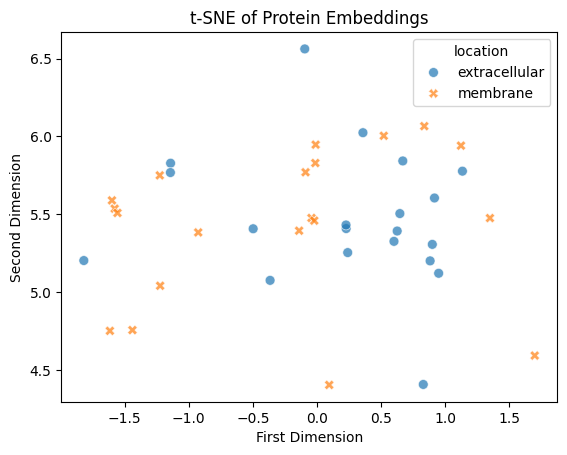

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

embeddings_tsne = TSNE(n_components=2, random_state=42).fit_transform(
  np.vstack(embeddings)
)
embeddings_tsne_df = pd.DataFrame(
  {
    "first_dimension": embeddings_tsne[:, 0],
    "second_dimension": embeddings_tsne[:, 1],
    "location": np.array(labels),
  }
)

fig = sns.scatterplot(
  data=embeddings_tsne_df,
  x="first_dimension",
  y="second_dimension",
  hue="location",
  style="location",
  s=50,
  alpha=0.7,
)
plt.title("t-SNE of Protein Embeddings")
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension");



While the separation isn’t perfect, there’s a clear trend: extracellular proteins tend to cluster in a different region of embedding space than membrane ones. It’s quite striking that the model picks up on this purely from sequence. This suggests that the learned embeddings reflect biologically meaningful patterns—even without any explicit supervision for cellular location.

With this initial exploration complete, we now turn to the central machine learning task of this tutorial: predicting protein function. Let’s begin by preparing the dataset.


## Preparing the Data

Many machine learning books and blog posts jump straight into the exciting parts—training and evaluating models—as soon as possible. But in practice, training is often a small fraction of the overall workflow. A significant portion of time is spent understanding, cleaning, and structuring the data. And when things go wrong with a model, the root cause is often found in the data. So, rather than handing you a polished CSV from the ether, we'll walk through the data preparation process step by step—starting from real-world resources and working through the steps needed to turn them into something a model can use.

Our goal is to fine-tune a model to predict protein function from sequence, which means assembling a dataset of `(protein_sequence, protein_function)` pairs. Fortunately, biologists have developed systematic frameworks for defining protein functions, and curated datasets already exist. One of the most widely used resources is the [CAFA (Critical Assessment of Functional Annotation)](https://biofunctionprediction.org/cafa/) challenge, a community-driven competition where teams build models to predict protein function. We'll use CAFA data as our raw material, but we'll still need to process and structure it ourselves.

```{note}
If you're familiar with AlphaFold and protein structure prediction, you may have heard of the similarly named CASP (Critical Assessment of Structure Prediction), which plays a similar role in the protein structure community. Public benchmarks like these have been instrumental in driving progress across a wide range of computational biology problems.
```

Let’s now explore the CAFA dataset.



### Loading the CAFA3 Data

There have been several rounds of CAFA, but the CAFA3 dataset is the most recent publicly available one. We first downloaded the "CAFA3 Targets" and "CAFA3 Training Data" files from the CAFA [website](https://biofunctionprediction.org/cafa/). Let’s start by loading the label file, which tells us the functional annotations for each protein:


In [ ]:
import os
ROOT_DIR = '/content/drive/MyDrive/Book/Chapter_2_LM_protein_function/'

labels = pd.read_csv(os.path.join(ROOT_DIR, 'train_terms.tsv.zip'),
                     sep='\t', compression='infer')
labels

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO
...,...,...,...
5363858,X5L565,GO:0050649,MFO
5363859,X5L565,GO:0016491,MFO
5363860,X5M5N0,GO:0005515,MFO
5363861,X5M5N0,GO:0005488,MFO



This dataframe contains three columns:

- `EntryID`: the UniProt ID of the protein.
- `term`: a GO (Gene Ontology) accession code describing a specific protein function.
- `aspect`: the GO category the function belongs to one of three types of function described in the introduction:
  - *BPO*: Biological Process.
  - *MFO*: Molecular Function.
  - *CCO*: Cellular Component.

The `term` column contains only GO accession codes. To make these more interpretable, we’d ideally like to know their human-readable descriptions. This information isn’t included directly in the CAFA files, but it is available via the [Gene Ontology downloads page](https://geneontology.org/docs/download-ontology/). The ontology is stored in graph format as an `.obo` file, and we can use the `obonet` Python library to parse it. Here’s how we retrieve the term descriptions:

In [ ]:
import obonet

def get_go_term_descriptions() -> pd.DataFrame:
  """Fetch mapping between GO terms and their descriptions from GO source."""
  url = 'https://current.geneontology.org/ontology/go-basic.obo'
  graph = obonet.read_obo(url)

  # Extract GO term IDs and names from the graph nodes.
  id_to_name = {id: data.get('name') for id, data in graph.nodes(data=True)}
  go_term_descriptions = pd.DataFrame(
      zip(id_to_name.keys(), id_to_name.values()),
      columns=['term', 'description'])
  return go_term_descriptions



The function will load the annotations from a local file if it already exists, or download and cache them if not:

In [ ]:
go_term_descriptions = get_go_term_descriptions()
go_term_descriptions.head(5)

,term,description
0,GO:0000001,mitochondrion inheritance
1,GO:0000006,high-affinity zinc transmembrane transporter a...
2,GO:0000007,low-affinity zinc ion transmembrane transporte...
3,GO:0000009,"alpha-1,6-mannosyltransferase activity"
4,GO:0000010,heptaprenyl diphosphate synthase activity


We can then merge the human-readable term descriptions back onto the labels dataframe:


In [ ]:
labels = labels.merge(go_term_descriptions, on='term')
labels

,EntryID,term,aspect,description
0,A0A009IHW8,GO:0008152,BPO,metabolic process
1,A0A009IHW8,GO:0034655,BPO,nucleobase-containing compound catabolic process
2,A0A009IHW8,GO:0072523,BPO,purine-containing compound catabolic process
3,A0A009IHW8,GO:0006753,BPO,nucleoside phosphate metabolic process
4,A0A009IHW8,GO:1901292,BPO,nucleoside phosphate catabolic process
...,...,...,...,...
4897174,X5L565,GO:0050649,MFO,testosterone 6-beta-hydroxylase activity
4897175,X5L565,GO:0016491,MFO,oxidoreductase activity
4897176,X5M5N0,GO:0005515,MFO,protein binding
4897177,X5M5N0,GO:0005488,MFO,binding



In this tutorial, we’ll focus specifically on molecular functions (`MFO`)—that is, what a protein does at the biochemical level. Later, you may want to extend this tutorial's approach to include the other two GO categories.

Let’s take a look at which molecular functions are most commonly annotated in the dataset:

In [ ]:
labels = labels[labels["aspect"] == "MFO"]
print(labels["description"].value_counts())

description
molecular_function                                              78637
binding                                                         57380
protein binding                                                 47987
catalytic activity                                              25324
heterocyclic compound binding                                   12694
                                                                ...  
saccharopine oxidase activity                                       1
neutral, basic amino acid:sodium:chloride symporter activity        1
bisphosphoglycerate 3-phosphatase activity                          1
myosin II head/neck binding                                         1
cystine:glutamate antiporter activity                               1
Name: count, Length: 6918, dtype: int64



We can already see that the distribution of function annotations is highly skewed. Some terms—like `molecular_function`, `binding`, and `protein binding`—appear tens of thousands of times, while others occur only once. Labels like `molecular_function` are overly generic and provide little meaningful information, making them unhelpful for machine learning. We’ll filter these out in a later step.

Next, let's load the protein sequences associated with each protein ID. This information is stored in the file `train_sequences.fasta`, a standard format for representing biological sequences such as proteins and DNA. We can use BioPython's `SeqIO` module to parse the `.fasta` file into a format we can work with.

```{note}
A quick aside: no one starts out knowing what BioPython’s `SeqIO` module is, or how `.fasta` files work, or what GO annotations mean—and that’s completely normal. Working at the intersection of biology and machine learning means constantly encountering new tools and terminology. Frequent looking up of new terms and tools is not just okay–it's expected.
```

We'll convert the `.fasta` sequences into a pandas dataframe to make them easier to manipulate:

In [ ]:
from Bio import SeqIO

sequences_file = os.path.join(ROOT_DIR, 'train_sequences.fasta')
fasta_sequences = SeqIO.parse(open(sequences_file), "fasta")

data = []
for fasta in fasta_sequences:
  data.append(
    {
      "EntryID": fasta.id,
      "Sequence": str(fasta.seq),
      "Length": len(fasta.seq),
    }
  )
sequence_df = pd.DataFrame(data)
sequence_df

,EntryID,Sequence,Length
0,P20536,MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...,218
1,O73864,MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...,354
2,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258
3,A0A0B4J1F4,MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...,415
4,P54366,MVETNSPPAGYTLKRSPSDLGEQQQPPRQISRSPGNTAAYHLTTAM...,415
...,...,...,...
142241,A0A286YAI0,METEVDDFPGKASIFSQVNPLYSNNMKLCEAERYDFQHSEPKTMKS...,450
142242,A0A1D5NUC4,MSAAASAEMIETPPVLNFEEIDYKEIEVEEVVGRGAFGVVCKAKWR...,643
142243,Q5RGB0,MADKGPILTSVIIFYLSIGAAIFQILEEPNLNSAVDDYKNKTNNLL...,448
142244,A0A2R8QMZ5,MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...,459




We’ve also computed the length of each sequence, since protein lengths can vary widely and this information will be useful later when filtering data.

One important detail: the CAFA dataset includes proteins from many different organisms. To isolate human proteins, we’ll use the associated taxonomy file provided in the download:

In [ ]:
taxonomy_file = os.path.join(ROOT_DIR, 'train_taxonomy.tsv.zip')
taxonomy = pd.read_csv(taxonomy_file, sep="\t", compression="infer")
taxonomy

,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431
...,...,...
142241,Q5TD07,9606
142242,A8BB17,7955
142243,A0A2R8QBB1,7955
142244,P0CT72,284812



This file contains a taxonomy ID (`taxonomyID`) for each protein, based on NCBI's organism classification system. We’ll merge this onto our sequence dataframe and keep only proteins with `taxonomyID == 9606`, which corresponds to *Homo sapiens*:

In [ ]:
sequence_df = sequence_df.merge(taxonomy, on="EntryID")
sequence_df = sequence_df[sequence_df["taxonomyID"] == 9606]

In [ ]:
sequence_df

,EntryID,Sequence,Length,taxonomyID
2,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606
5,P33681,MGHTRRQGTSPSKCPYLNFFQLLVLAGLSHFCSGVIHVTKEVKEVA...,288,9606
7,Q16787,MAAAARPRGRALGPVLPPTPLLLLVLRVLPACGATARDPGAAAGLS...,3333,9606
10,Q96S79,MVSTYRVAVLGARGVGKSAIVRQFLYNEFSEVCVPTTARRLYLPAV...,203,9606
14,Q5MNZ6,MNLLPCNPHGNGLLYAGFNQDHGCFACGMENGFRVYNTDPLKEKEK...,344,9606
...,...,...,...,...
142176,H0YJP4,XSVAGIVCHVGKAEDREQLVAKALEHCGGVDFLVCSAGVNPLVGST...,180,9606
142191,A0A0C4DGS2,MVVLNPMTLGIYLQLFFLSIVSQPTFINSVLPISAALPSLDQKKRG...,456,9606
142205,E9PLN0,MARRPRHSIYSSDEDDEDFEMCDHDYDGLLPKSGKRHLGKTRWTRE...,611,9606
142211,E7ER32,MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...,798,9606


Now let’s get an overview of the number of unique proteins and molecular function terms in our filtered dataset:


In [ ]:
sequence_df = sequence_df.merge(labels, on="EntryID")
print(
  f'Dataset contains {sequence_df["EntryID"].nunique()} human proteins '
  f'with {sequence_df["term"].nunique()} molecular functions.'
)

Dataset contains 16336 human proteins with 4066 molecular functions.



Let’s also take a look at the resulting `sequence_df` after merging in the function labels:

In [ ]:
sequence_df

,EntryID,Sequence,Length,taxonomyID,term,aspect,description
0,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:0003676,MFO,nucleic acid binding
1,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:1990837,MFO,sequence-specific double-stranded DNA binding
2,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:0001216,MFO,DNA-binding transcription activator activity
3,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:0005488,MFO,binding
4,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:0001228,MFO,"DNA-binding transcription activator activity, ..."
...,...,...,...,...,...,...,...
150949,Q549H9,MMEVESSYSDFISCDRTGRRNAVPDIQGDSEAVSVRKLAGDMGELA...,76,9606,GO:0005488,MFO,binding
150950,Q549H9,MMEVESSYSDFISCDRTGRRNAVPDIQGDSEAVSVRKLAGDMGELA...,76,9606,GO:0003674,MFO,molecular_function
150951,Q86TI6,MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...,347,9606,GO:0005515,MFO,protein binding
150952,Q86TI6,MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...,347,9606,GO:0005488,MFO,binding


From this table, we can already see that many proteins are associated with multiple molecular functions. To quantify this, we examine the distribution of the number of functions per protein:


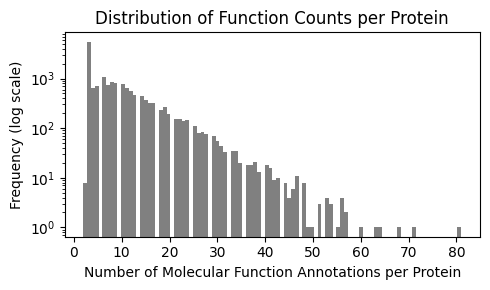

In [ ]:
sequence_df.groupby("EntryID")["term"].nunique().plot.hist(
  bins=100, figsize=(5, 3), color="grey", log=True
)
plt.xlabel("Number of Molecular Function Annotations per Protein")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Function Counts per Protein")
plt.tight_layout()


This pattern reflects a complex biological reality: while many proteins carry out a single, well-defined function, others are involved in a wide variety of molecular roles. For example, some proteins act as enzymes, bind to other molecules, and participate in multiple pathways. From a machine learning perspective, this means our model must be able to assign multiple function labels to a single protein, and also cope with the fact that some labels are much rarer than others.

Let’s now take a closer look at the most frequent molecular function labels. Some terms are so broad and universally assigned that they offer little meaningful insight. For example, `molecular function` applies to nearly all proteins, `binding` covers 93%, and `protein binding` appears in 89% of cases. These labels will tend to dominate the loss during training and can cause the model to fixate on predicting them at the expense of more meaningful functions. As a dataset preprocessing step, we’ll explicitly remove these overly generic terms:


In [ ]:
uninteresting_functions = [
  "GO:0003674",  # "molecular function". Applies to 100% of proteins.
  "GO:0005488",  # "binding". Applies to 93% of proteins.
  "GO:0005515",  # "protein binding". Applies to 89% of proteins.
]

sequence_df = sequence_df[~sequence_df["term"].isin(uninteresting_functions)]
sequence_df.shape

(104929, 7)

On the opposite end of the spectrum, some molecular functions are extremely rare—for example, `GO:0099609` (microtubule lateral binding) appears only once. To learn meaningful associations, our model needs enough training examples per function. So we’ll filter out the rarest labels and keep only those that appear in at least 50 proteins:


In [ ]:
common_functions = (
  sequence_df["term"]
  .value_counts()[sequence_df["term"].value_counts() >= 50]
  .index
)

sequence_df = sequence_df[sequence_df["term"].isin(common_functions)]
sequence_df["term"].value_counts()

,count
term,
GO:0003824,3875
GO:1901363,2943
GO:0003676,2469
GO:0042802,1803
GO:0016740,1652
...,...
GO:0004714,52
GO:0031490,51
GO:0005516,51


This gives us a cleaner set of function labels that are more amenable to learning.




```{note}
Thresholds used during data processing—like how many times a label must appear to be included—are somewhat arbitrary, but they can significantly affect model performance. These decisions are effectively hyperparameters and should be tuned based on the specific task, dataset size, and model capacity.
```

Now we'll reshape the dataframe so that each row corresponds to one protein, and each column corresponds to a molecular function label. We’ll use the `pivot` function in pandas to create this multi-label format:


In [ ]:
sequence_df = (
  sequence_df[["EntryID", "Sequence", "Length", "term"]]
  .assign(value=1)
  .pivot(
    index=["EntryID", "Sequence", "Length"], columns="term", values="value"
  )
  .fillna(0)
  .astype(int)
  .reset_index()
)
sequence_df

term,EntryID,Sequence,Length,GO:0000166,GO:0000287,GO:0000976,GO:0000977,GO:0000978,GO:0000981,GO:0000987,...,GO:0140677,GO:0140678,GO:1901265,GO:1901363,GO:1901681,GO:1901702,GO:1901981,GO:1902936,GO:1990782,GO:1990837
0,A0A024R6B2,MIASCLCYLLLPATRLFRALSDAFFTCRKNVLLANSSSPQVEGDFA...,670,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A0A087WUI6,MSRKISKESKKVNISSSLESEDISLETTVPTDDISSSEEREGKVRI...,698,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,515,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A0A0C4DG62,MAHVGSRKRSRSRSRSRGRGSEKRKKKSRKDTSRNCSASTSQERSK...,218,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A0A0C4DGF1,MSLPPIRLPSPYGSDRLVQLAARLRPALCDTLITVGSQEFPAHSLV...,302,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10704,Q9Y6Y8,MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...,1000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10705,Q9Y6Y9,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,160,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10706,Q9Y6Z7,MNGFASLLRRNQFILLVLFLLQIQSLGLDIDSRPTAEVCATHTISP...,277,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10707,X5D778,MPKGGCPKAPQQEELPLSSDMVEKQTGKKDKDKVSLTKTPKLERGD...,421,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Great—this dataset is now in a format that's almost ready for machine learning. Before we move on, let’s run a few final sanity checks.

First, how many unique proteins do we have?

In [ ]:
sequence_df["EntryID"].nunique()

10709

This number is in the right ballpark. There are roughly 21,000 protein-coding genes in the human genome, and since we applied several filtering steps, we expect a somewhat smaller number. It’s always worth keeping rough order-of-magnitude expectations in mind—if we saw 1,000 or 1,000,000 here, we’d know something was off.

Next, let’s check whether any protein sequences are duplicated:

In [ ]:
sequence_df["Sequence"].nunique()

10698

It seems that a few protein sequences are repeated. For example, the entries `P0DP23`, `P0DP24`, and `P0DP25` all share the same sequence:

In [ ]:
sequence_df[sequence_df["EntryID"].isin(["P0DP23", "P0DP24", "P0DP25"])]

term,EntryID,Sequence,Length,GO:0000166,GO:0000287,GO:0000976,GO:0000977,GO:0000978,GO:0000981,GO:0000987,...,GO:0140677,GO:0140678,GO:1901265,GO:1901363,GO:1901681,GO:1901702,GO:1901981,GO:1902936,GO:1990782,GO:1990837
1945,P0DP23,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...,149,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1946,P0DP24,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...,149,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1947,P0DP25,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...,149,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0



These seem to be legitimate biological duplicates—proteins with different Uniprot identifiers but identical sequences—so we’ll keep them in the dataset.

At this point, we have a final dataset linking 10,709 human proteins to one or more of 305 molecular functions.

Since our simple mean embedding approach can be quite memory intensive, we'll filter the dataset to include only proteins with a maximum length of 500 amino acids. This helps avoid out-of-memory errors during model inference and training:

In [ ]:
print(sequence_df.shape)
sequence_df = sequence_df[sequence_df["Length"] <= 500]
print(sequence_df.shape)

(10709, 300)
(5957, 300)



This roughly halves the dataset, which is perfectly fine for initial prototyping. You can always remove this constraint later if time and memory allows.

Now that we have a clean and compact dataset, let’s process it further for compatibility with machine learning.


### Splitting the Dataset into Subsets

We’ll split our dataset into three distinct subsets:

- *Training set* – used to fit the model. The model sees this data during training and uses it to learn patterns.
- *Validation set* – used to evaluate the model’s performance during development. We use this to tune hyperparameters and compare model variants.
- *Test set* – used only once, for final evaluation. Crucially, we avoid using this data to guide model design decisions. It serves as our best estimate of how well the model would generalize to completely unseen data.

We’ll split the proteins by their `EntryID`, ensuring that each protein appears in only one subset:

In [ ]:
from sklearn.model_selection import train_test_split

# 60% of the proteins will go into the training set.
train_sequence_ids, valid_test_sequence_ids = train_test_split(
  list(set(sequence_df["EntryID"])), test_size=0.40, random_state=42
)

# Split the remaining 40% evenly between validation and test sets.
valid_sequence_ids, test_sequence_ids = train_test_split(
  valid_test_sequence_ids, test_size=0.50, random_state=42
)

Now we’ll extract the rows for each split from our dataframe `sequence_df`:

In [ ]:
sequence_splits = {
  "train": sequence_df[sequence_df["EntryID"].isin(train_sequence_ids)],
  "valid": sequence_df[sequence_df["EntryID"].isin(valid_sequence_ids)],
  "test": sequence_df[sequence_df["EntryID"].isin(test_sequence_ids)],
}

for split, df in sequence_splits.items():
  print(f"{split} has {len(df)} entries.")

train has 3574 entries.
valid has 1191 entries.
test has 1192 entries.


This gives us clean, non-overlapping training, validation, and test sets—each containing a subset of proteins we'll use throughout model development and evaluation.




### Converting Protein Sequences Into Their Mean Embeddings

We will now convert the sequences from each dataset split into their corresponding mean embeddings, just as we did earlier. Since this step can be time-consuming—especially with larger models—it’s worth thinking about how to do it efficiently. Using a GPU can significantly speed up computation, but we can also avoid repeating work by computing the embeddings only once, storing them to disk and loading them later.

To make this process more convenient, we’ll use a pair of helper functions to store and load sequence embeddings:

In [ ]:
from math import ceil
from tqdm.notebook import tqdm

def store_sequence_embeddings(
  sequence_df: pd.DataFrame,
  store_prefix: str,
  tokenizer: PreTrainedTokenizer,
  model: PreTrainedModel,
  batch_size: int = 64,
  force: bool = False,
) -> None:
  """Extract and store mean embeddings for each protein sequence."""
  model_name = str(model.name_or_path).replace("/", "_")
  store_file = f"{store_prefix}_{model_name}.feather"

  if not os.path.exists(store_file) or force:
    device = get_device()

    # Iterate through protein dataframe in batches, extracting embeddings.
    n_batches = ceil(sequence_df.shape[0] / batch_size)
    batches: list[np.ndarray] = []
    for i in tqdm(range(n_batches)):
      batch_seqs = list(
        sequence_df["Sequence"][i * batch_size : (i + 1) * batch_size]
      )
      batches.extend(get_mean_embeddings(batch_seqs, tokenizer, model, device))

    # Store each of the embedding values in a separate column in the dataframe.
    embeddings = pd.DataFrame(np.vstack(batches))
    embeddings.columns = [f"ME:{int(i)+1}" for i in range(embeddings.shape[1])]
    df = pd.concat([sequence_df.reset_index(drop=True), embeddings], axis=1)
    df.to_feather(store_file)


Let’s use the more powerful (but computationally expensive) ESM2 model with 640-dimensional embeddings and store the embeddings for each split using the `store_sequence_embeddings` function.

Let's just extract the embeddings for 2 batches (64 proteins per batch) to see how it works:

In [ ]:
model_checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

for split, df in sequence_splits.items():
  store_prefix = os.path.join(
    ROOT_DIR,
    f"protein_embedding_dataset_{split}"
  )
  store_sequence_embeddings(
    sequence_df=df,
    store_prefix=store_prefix,
    tokenizer=tokenizer,
    model=model,
    force=True,
  )

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


Once stored, we can load the embeddings back into memory whenever needed. It takes a few minutes to extract the embeddings for the train, valid and test tests using this larger model on a TF TPU, so here we will just load the precomputed embeddings. However, they were generated by simply running the function above on the full `df` rather than a small sample of it.

Here is a glimpse of the training dataset that the model will learn from:


In [ ]:
def load_sequence_embeddings(
  store_file_prefix: str, model_checkpoint: str
) -> pd.DataFrame:
  """Load stored embedding DataFrame from disk."""
  model_name = model_checkpoint.replace("/", "_")
  store_file = f"{store_file_prefix}_{model_name}.feather"
  return pd.read_feather(store_file)


store_prefix = os.path.join(
  ROOT_DIR,
  "protein_embedding_dataset_train"
)

train_df = load_sequence_embeddings(
  store_prefix,
  model_checkpoint=model_checkpoint,
)

train_df

,EntryID,Sequence,Length,GO:0000166,GO:0000287,GO:0000976,GO:0000977,GO:0000978,GO:0000981,GO:0000987,...,ME:631,ME:632,ME:633,ME:634,ME:635,ME:636,ME:637,ME:638,ME:639,ME:640
0,A0A0C4DG62,MAHVGSRKRSRSRSRSRGRGSEKRKKKSRKDTSRNCSASTSQERSK...,218,0,0,0,0,0,0,0,...,0.120204,0.008297,0.258974,-0.132809,0.064346,0.066939,0.039797,0.029255,-0.028089,0.029445
1,A0A0C5B5G6,MRWQEMGYIFYPRKLR,16,0,0,0,0,0,0,0,...,0.248081,0.017740,0.333051,0.104199,0.292838,0.303421,-0.158697,-0.050868,-0.179603,0.038101
2,A0A1B0GTB2,MVITSENDEDRGGQEKESKEESVLAMLGIIGTILNLIVIIFVYIYTTL,48,0,0,0,0,0,0,0,...,0.157609,0.041810,0.180219,-0.034687,0.077907,0.141838,-0.043678,0.023668,-0.017420,0.132752
3,A0AVI4,MDSPEVTFTLAYLVFAVCFVFTPNEFHAAGLTVQNLLSGWLGSEDA...,362,0,0,0,0,0,0,0,...,0.050968,-0.072033,-0.412079,0.021588,-0.149667,0.160724,-0.075879,0.025675,-0.115748,0.025867
4,A0PJW6,MAAPWRRWPTGLLAVLRPLLTCRPLQGTTLQRDVLLFEHDRGRFFT...,202,0,0,0,0,0,0,0,...,0.012986,-0.106316,-0.006885,-0.126726,0.037537,0.142364,-0.065941,0.037374,-0.042673,-0.047216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3569,Q9Y6W6,MPPSPLDDRVVVALSRPVRPQDLNLCLDSSYLGSANPGSNSHPPVI...,482,0,0,0,0,0,0,0,...,-0.054951,0.071894,0.011167,-0.079443,-0.068406,0.121673,-0.086569,-0.016682,-0.107221,-0.076528
3570,Q9Y6X5,MKLLVILLFSGLITGFRSDSSSSLPPKLLLVSFDGFRADYLKNYEF...,453,0,0,0,0,0,0,0,...,-0.038760,0.041794,0.082078,-0.048283,0.061476,0.068948,-0.143561,0.013838,-0.142605,0.031377
3571,Q9Y6Y9,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,160,0,0,0,0,0,0,0,...,0.129841,0.022207,0.264162,0.013801,-0.002542,0.140853,-0.030082,0.079812,0.050532,0.104331
3572,Q9Y6Z7,MNGFASLLRRNQFILLVLFLLQIQSLGLDIDSRPTAEVCATHTISP...,277,0,0,0,0,0,0,0,...,0.088296,0.040393,0.272137,0.078628,0.065321,0.080641,0.023796,0.062326,-0.020288,0.021192



You’ll notice a series of columns labeled `ME:1` through `ME:640`. These represent the mean-pooled hidden states from the final layer of the ESM2 model—effectively a fixed-length numerical summary of each protein sequence. These embeddings capture biochemical and structural information learned during pretraining, and will serve as the input features for our classifier.

This dataframe becomes the input to a `convert_to_tfds` function, which we've defined to make it easier to prepare the datasets for each split.

In [ ]:
def convert_to_tfds(
  df: pd.DataFrame,
  embeddings_prefix: str = "ME:",
  target_prefix: str = "GO:",
  is_training: bool = False,
  shuffle_buffer: int = 50,
) -> tf.data.Dataset:
  """Convert embedding DataFrame into a TensorFlow dataset."""
  dataset = tf.data.Dataset.from_tensor_slices(
    {
      "embedding": df.filter(regex=f"^{embeddings_prefix}").to_numpy(),
      "target": df.filter(regex=f"^{target_prefix}").to_numpy(),
    }
  )
  if is_training:
    dataset = dataset.shuffle(shuffle_buffer).repeat()
  return dataset


Let’s now use our `convert_to_tfds` function to build a TensorFlow-compatible dataset from the training DataFrame:

In [ ]:
train_ds = convert_to_tfds(train_df, is_training=True)

Fetching a batch of data from these datasets is straightforward. We just batch the dataset, convert it to a NumPy iterator, and retrieve a batch by calling `next`:

In [ ]:
batch_size = 32

batch = next(train_ds.batch(batch_size).as_numpy_iterator())
batch["embedding"].shape, batch["target"].shape

((32, 640), (32, 297))


These shapes confirm that each input is a 640-dimensional embedding vector (from the ESM2 model), and each target is a 303-dimensional binary vector representing the presence or absence of each molecular function label.

```{tip}
Because the training dataset includes `.repeat()`, it yields batches indefinitely by looping over the data. This is useful for training, where we want to cycle through the dataset multiple times. In contrast, the validation and test datasets are not repeated—so their batches will eventually be exhausted, which is exactly what we want during evaluation, where each example should be seen only once.
```

To streamline the dataset setup, we’ve wrapped the entire pipeline into a single helper function `build_dataset`:

In [ ]:
def build_dataset(
  store_file_prefix: str, model_checkpoint: str
) -> dict[str, tf.data.Dataset]:
  """Build train/valid/test TensorFlow datasets from stored embeddings."""
  dataset_splits = {}

  for split in ["train", "valid", "test"]:
    dataset_splits[split] = convert_to_tfds(
      df=load_sequence_embeddings(
        store_file_prefix=f"{store_file_prefix}_{split}",
        model_checkpoint=model_checkpoint,
      ),
      is_training=(split == "train"),
    )
  return dataset_splits

This function loads the saved mean embeddings from disk for all three splits and constructs `tf.data.Dataset` objects that are ready for training:


In [ ]:
store_prefix = os.path.join(
    ROOT_DIR,
    "protein_embedding_dataset"
)

dataset_splits = build_dataset(
    store_file_prefix=store_prefix,
    model_checkpoint=model_checkpoint,
)
dataset_splits

{'train': <_RepeatDataset element_spec={'embedding': TensorSpec(shape=(640,), dtype=tf.float32, name=None), 'target': TensorSpec(shape=(297,), dtype=tf.int64, name=None)}>,
 'valid': <_TensorSliceDataset element_spec={'embedding': TensorSpec(shape=(640,), dtype=tf.float32, name=None), 'target': TensorSpec(shape=(297,), dtype=tf.int64, name=None)}>,
 'test': <_TensorSliceDataset element_spec={'embedding': TensorSpec(shape=(640,), dtype=tf.float32, name=None), 'target': TensorSpec(shape=(297,), dtype=tf.int64, name=None)}>}

With this, we now have our data fully preprocessed and ready to use in training a model.


## Training the Model

We will now train a simple Flax linear model on top of the mean protein embeddings. Recall that each protein sequence has a variable length, but we’ve already transformed them into fixed-size embeddings. Our goal is to predict which of the 303 molecular functions each protein performs. This is a _multi-label classification_ problem, meaning each protein may be associated with several function labels simultaneously.

In this setup, we’ll train a lightweight MLP (multi-layer perceptron)—a stack of dense layers with nonlinearities. Importantly, we are not fine-tuning the original ESM2 model: it remains frozen, and our model simply learns on top of its embeddings.

Here's the model code:

In [ ]:
import flax.linen as nn
import jax
from flax.training.train_state import TrainState


class Model(nn.Module):
  """Simple MLP for protein function prediction."""

  num_targets: int
  dim: int = 256

  @nn.compact
  def __call__(self, x):
    """Apply MLP layers to input features."""
    x = nn.Sequential(
      [
        nn.Dense(self.dim * 2),
        jax.nn.gelu,
        nn.Dense(self.dim),
        jax.nn.gelu,
        nn.Dense(self.num_targets),
      ]
    )(x)
    return x

  def create_train_state(self, rng: jax.Array, dummy_input, tx) -> TrainState:
    """Initialize model parameters and return a training state."""
    variables = self.init(rng, dummy_input)
    return TrainState.create(
      apply_fn=self.apply, params=variables["params"], tx=tx
    )



Some notes on this very lightweight model:

- It uses `nn.Sequential` to stack layers, which keeps the definition clean and readable for this simple model.
- We use a GELU (Gaussian Error Linear Unit) activation function, which is a smooth, non-linear alternative to ReLU.
- The final layer is a `nn.Dense` layer projecting to the number of function labels (`num_targets`). It returns logits, not probabilities—so we'll apply a suitable activation (like sigmoid) inside the loss function to convert these logits into predicted probabilities.
- This model is frozen on top of the ESM2 embeddings—meaning it does not update the transformer weights. It learns only to map fixed embeddings to functional labels. This is efficient, interpretable, and reduces memory usage during training.

You may also have noticed that we attached a convenience function `create_train_state` to the model class for creating a training state. This encapsulates model initialization, parameter registration, and optimizer setup into a single `TrainState` object. It’s particularly useful because it allows us to construct the training state right when everything needed—model, dummy input for shape inference, and optimizer config—is readily available.

Let’s instantiate the model with the correct number of output targets, based on how many GO term columns we have in the training dataframe:

In [ ]:
targets = list(train_df.columns[train_df.columns.str.contains("GO:")])

mlp = Model(num_targets=len(targets))
mlp

Model(
    # attributes
    num_targets = 297
    dim = 256
)

This model is now ready to be trained to predict which molecular functions a protein is involved in, using the precomputed embeddings as input.


### Defining the Training Loop

With the model and dataset ready, we can now define a function to perform a single training step. This step includes:

- A forward pass through the model.
- Computing the loss.
- Calculating gradients.
- Updating the model parameters using those gradients.

Here’s how we implement it:

In [ ]:
@jax.jit
def train_step(state, batch):
  """Run a single training step and update model parameters."""

  def calculate_loss(params):
    """Compute sigmoid cross-entropy loss from logits."""
    logits = state.apply_fn({"params": params}, x=batch["embedding"])
    loss = optax.sigmoid_binary_cross_entropy(logits, batch["target"]).mean()
    return loss

  grad_fn = jax.value_and_grad(calculate_loss, has_aux=False)
  loss, grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state, loss


In this setup:

- We use a sigmoid activation and binary cross-entropy loss, appropriate for multi-label classification. The logits go through a sigmoid activation, not softmax — because we want independent yes/no predictions for each possible protein function.
- `@jax.jit` compiles the training step for better performance.

Next, let’s implement some metrics to evaluate how well the model is doing beyond the loss alone, using tools from `sklearn`:

In [ ]:
from sklearn import metrics as sklearn_metrics

def compute_metrics(
  targets: np.ndarray, probs: np.ndarray, thresh=0.5
) -> dict[str, float]:
  """Compute accuracy, recall, precision, auPRC, and auROC."""
  if np.sum(targets) == 0:
    return {
      m: 0.0 for m in ["accuracy", "recall", "precision", "auprc", "auroc"]
    }
  return {
    "accuracy": sklearn_metrics.accuracy_score(targets, probs >= thresh),
    "recall": sklearn_metrics.recall_score(targets, probs >= thresh),
    "precision": sklearn_metrics.precision_score(
      targets,
      probs >= thresh,
      zero_division=0.0,
    ),
    "auprc": sklearn_metrics.average_precision_score(targets, probs),
    "auroc": sklearn_metrics.roc_auc_score(targets, probs),
  }


We’ll track the following evaluation metrics for each function label:

- _Accuracy_: The fraction of correct predictions across all labels. In multi-label classification with imbalanced data (like this), accuracy can be misleading—most labels are zero, so a model that always predicts “no function” would appear accurate. Still, it's an intuitive metric and we’ll include it for now.
- _Recall_: The proportion of actual function labels the model correctly predicted (i.e., true positives / all actual positives). High recall means the model doesn't miss many true functions.
- _Precision_: The proportion of predicted function labels that are correct (i.e., true positives / all predicted positives). High precision means the model avoids false alarms.
- _auPRC (Area Under the Precision-Recall Curve)_: Summarizes the tradeoff between precision and recall at different thresholds. Particularly useful in highly imbalanced settings like this one.
- _auROC (Area Under the Receiver Operating Characteristic Curve)_: Measures the model's ability to distinguish positive from negative examples across all thresholds. While it’s a standard metric of discrimination ability, it can sometimes be misleading in highly imbalanced datasets, as it gives equal weight to both classes.

In a multilabel setting, we calculate these metrics for each protein function (i.e., per target/label), then average them to get a holistic view of model performance.

We apply these metrics calculations during the evaluation step `eval_step`:

In [ ]:
def calculate_per_target_metrics(logits, targets):
  """Compute metrics for each target in a multi-label batch."""
  probs = jax.nn.sigmoid(logits)
  target_metrics = []
  for target, prob in zip(targets, probs):
    target_metrics.append(compute_metrics(target, prob))
  return target_metrics

def eval_step(state, batch) -> dict[str, float]:
  """Run evaluation step and return mean metrics over targets."""
  logits = state.apply_fn({"params": state.params}, x=batch["embedding"])
  loss = optax.sigmoid_binary_cross_entropy(logits, batch["target"]).mean()
  target_metrics = calculate_per_target_metrics(logits, batch["target"])
  return {
    "loss": loss.item(),
    **pd.DataFrame(target_metrics).mean(axis=0).to_dict(),
  }


The evaluation computes metrics per protein in the batch. For each protein, we:

- Apply `sigmoid` to its 303 logits to get function probabilities.
- Threshold those probabilities (e.g. at 0.5) to get binary predictions.
- Compare these to the true function labels to compute metrics like accuracy, precision, recall, auPRC, and auROC.

We repeat this for every protein in the batch, then average the resulting metrics across proteins. This tells us how well the model predicts sets of functions per protein. It does not report performance per GO term - if we wanted per-function metrics (e.g. how well the model predicts `GO:0003677`), we’d need to compute metrics column-wise instead.

In the next chunk of code, everything comes together into a `train` function. We have the training loop where we first initialize our model training state, and then loop over the dataset in batches to train the model and evaluate it every so often:


In [ ]:

def train(
  state: TrainState,
  dataset_splits: dict[str, tf.data.Dataset],
  batch_size: int,
  num_steps: int = 300,
  eval_every: int = 30,
):
  """Train model using batched TF datasets and track performance metrics."""
  # Create containers to handle calculated during training and evaluation.
  train_metrics, valid_metrics = [], []

  # Create batched dataset to pluck batches from for each step.
  train_batches = (
    dataset_splits["train"]
    .batch(batch_size, drop_remainder=True)
    .as_numpy_iterator()
  )

  steps = tqdm(range(num_steps))  # Steps with progress bar.
  for step in steps:
    steps.set_description(f"Step {step + 1}")

    # Get batch of training data, convert into a JAX array, and train.
    state, loss = train_step(state, next(train_batches))
    train_metrics.append({"step": step, "loss": loss.item()})

    if step % eval_every == 0:
      # For all the evaluation batches, calculate metrics.
      eval_metrics = []
      for eval_batch in (
        dataset_splits["valid"].batch(batch_size=batch_size).as_numpy_iterator()
      ):
        eval_metrics.append(eval_step(state, eval_batch))
      valid_metrics.append(
        {"step": step, **pd.DataFrame(eval_metrics).mean(axis=0).to_dict()}
      )

  return state, {"train": train_metrics, "valid": valid_metrics}



A few notes on this training loop:

- *Efficient batch sampling*: Training data is streamed via `.as_numpy_iterator()`, and the `.repeat()` in the dataset ensures infinite looping over the data.
- *Regular evaluation*: Every `eval_every` steps, the model is evaluated on the full validation set to monitor progress using metrics we defined previously like auPRC and auROC.
- *Metric aggregation*: Validation metrics are computed batch-wise and then averaged across all batches using `pd.DataFrame(...).mean(axis=0)`. This gives a stable estimate of performance across the entire validation set.

Let’s now train the model. But first, a quick trick: to avoid unnecessarily repeating training from scratch every time you re-run your code cell, we use the `@restorable` decorator. This lightweight utility checks whether a trained model already exists at a specified path. If it does, it:

- Skips retraining,
- Restores the model into a valid `TrainState`,
- Returns the model along with any saved metrics.

This makes your workflow much faster and more reproducible, especially during iterative development and debugging. Let's have a look at how this is used:

In [ ]:

import optax

# Initiate training state with dummy data from a single batch.
rng = jax.random.PRNGKey(42)
rng, rng_init = jax.random.split(key=rng, num=2)

state, metrics = train(
  state=mlp.create_train_state(
    rng=rng_init, dummy_input=batch["embedding"], tx=optax.adam(0.001)
  ),
  dataset_splits=dataset_splits,
  batch_size=32,
  num_steps=300,
  eval_every=30,
)

  0%|          | 0/300 [00:00<?, ?it/s]


Some additional parameters worth mentioning here are the optimizer (here `optax.adam`) and the total number of training steps (`num_steps`). Given that we have about 2100 training examples and a batch size of 32, it will take about 66 steps for the model to see the entire training set once. Setting `num_steps=300` means the model will see each training data point several times.

Having trained the model with the train call above, we can now evaluate its training dynamics and performance on the validation set as seen below:

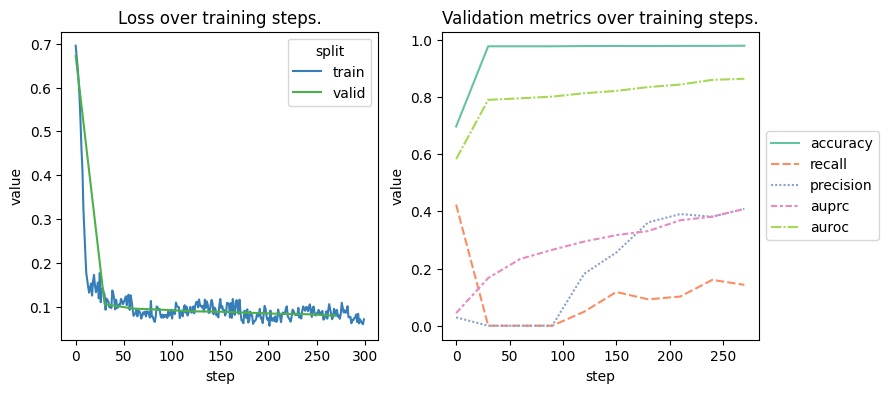

In [ ]:
from collections import OrderedDict

NAMED_COLORS = OrderedDict(
  [
    ("red", "#e41a1c"),
    ("blue", "#377eb8"),
    ("green", "#4daf4a"),
    ("purple", "#984ea3"),
    ("orange", "#ff7f00"),
    ("yellow", "#ffff33"),
    ("brown", "#a65628"),
    ("pink", "#f781bf"),
    ("gray", "#999999"),
  ]
)

DEFAULT_SPLIT_COLORS = {
  "train": NAMED_COLORS["blue"],
  "valid": NAMED_COLORS["green"],
  "test": NAMED_COLORS["orange"],
}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Plot training loss curve.
learning_data = pd.concat(
  pd.DataFrame(metrics[split]).melt("step").assign(split=split)
  for split in ["train", "valid"]
)

sns.lineplot(
  ax=ax[0],
  x="step",
  y="value",
  hue="split",
  data=learning_data[learning_data["variable"] == "loss"],
  palette=DEFAULT_SPLIT_COLORS,
)
ax[0].set_title("Loss over training steps.")

# Plot validation metrics curves.
sns.lineplot(
  ax=ax[1],
  x="step",
  y="value",
  hue="variable",
  style="variable",
  data=learning_data[learning_data["variable"] != "loss"],
  palette="Set2",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set_title("Validation metrics over training steps.");


In the left panel, we observe that both training and validation loss drop sharply within the first ~30 steps and then stabilize. This is a typical learning curve, indicating rapid convergence without substantial instability (e.g., no major spikes or divergence). It suggests that the model—a shallow MLP operating on top of frozen pretrained embeddings—quickly captures the low-hanging signal in the data.

In the right panel, we track several evaluation metrics over time:

- Accuracy and auROC start high and remain flat, but these can be misleading in imbalanced, multi-label settings like this one. Since most function labels are negative (i.e., a protein lacks the majority of all possible functions), a model that mostly predicts zeros can still achieve a high score on these metrics. For that reason, we don't put much weight on these metrics in this context.
- auPRC (pink line) steadily improves and does not fully plateau, suggesting the model continues to learn subtle distinctions and could potentially benefit from further training (i.e. by increasing `num_steps`).
- Precision improves faster than recall, indicating the model becomes increasingly confident in its predictions but still fails to capture some true positives.

Together, these trends indicate that while most of the learning happens early on, there may still be headroom—particularly in recall and auPRC—if training were extended further or if a more powerful architecture were used.

It's great to see the model training successfully and loss and metrics curves trending in the right direction—but that’s just the beginning. The real insight comes from analyzing the model's predictions, understanding where it performs well, and identifying its limitations.


### Examining the Model Predictions

With a trained model in hand, it's time to explore its strengths and weaknesses. We'll start by generating predictions for the entire validation set and storing them in a DataFrame for easier inspection:


In [ ]:
valid_df = load_sequence_embeddings(
  store_file_prefix=f"{store_prefix}_valid",
  model_checkpoint=model_checkpoint,
)

# Use batch size of 1 to avoid dropping the remainder.
valid_probs = []
for valid_batch in dataset_splits["valid"].batch(1).as_numpy_iterator():
  logits = state.apply_fn({"params": state.params}, x=valid_batch["embedding"])
  valid_probs.extend(jax.nn.sigmoid(logits))

valid_true_df = valid_df[["EntryID"] + targets].set_index("EntryID")
valid_prob_df = pd.DataFrame(
  np.stack(valid_probs), columns=targets, index=valid_true_df.index
)


To get a high-level sense of how the model is performing, we can visualize the full prediction matrix as a heatmap. Below, we plot two side-by-side heatmaps: one showing the true protein-function annotations (left), and the other showing the model's predicted probabilities (right). Each column corresponds to a protein function, and each row to a protein:

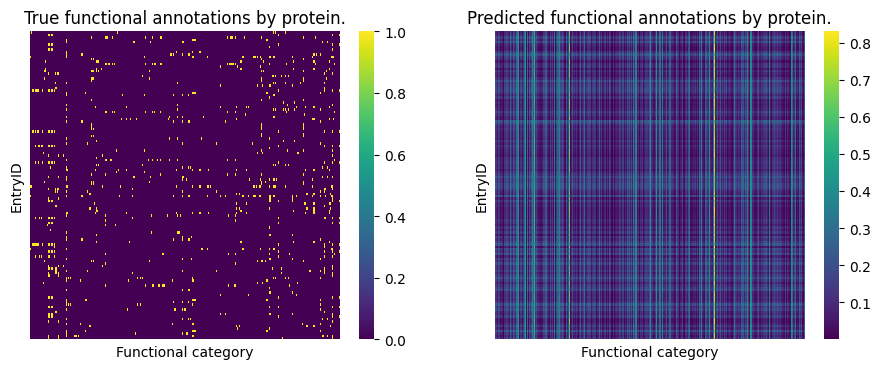

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))

sns.heatmap(
  ax=ax[0],
  data=valid_true_df,
  yticklabels=False,
  xticklabels=False,
  cmap="viridis",
)
ax[0].set_title("True functional annotations by protein.")
ax[0].set_xlabel("Functional category")

sns.heatmap(
  ax=ax[1],
  data=valid_prob_df,
  yticklabels=False,
  xticklabels=False,
  cmap="viridis",
)
ax[1].set_title("Predicted functional annotations by protein.")
ax[1].set_xlabel("Functional category");


This visualization is quite zoomed out and high-level, but it helps build intuition about overall model behavior:

- Some protein functions appear frequently in the dataset (visible as vertical stripes), and the model tends to predict these relatively well.
- Rare functions are harder to capture—the model often misses them entirely, leading to sparse or empty columns in the predicted heatmap.
- A few functions are over-predicted, visible as faint vertical lines across many proteins, suggesting the model is overly confident for those categories.
- Many cells in the predicted matrix show intermediate color tones (pink-orange), which reflect more uncertain probabilities (not a confident near-0 or near-1).

We’ll now shift from this qualitative view to a quantitative one by evaluating model performance on each protein function individually:

In [ ]:
metrics_by_function = {}
for function in targets:
  metrics_by_function[function] = compute_metrics(
    valid_true_df[function].values, valid_prob_df[function].values
  )

overview_valid = (
  pd.DataFrame(metrics_by_function)
  .T.merge(go_term_descriptions, left_index=True, right_on="term")
  .set_index("term")
  .sort_values("auprc", ascending=False)
)
overview_valid

,accuracy,recall,precision,auprc,auroc,description
term,,,,,,
GO:0004930,0.959698,0.000000,0.000000,0.878833,0.986202,G protein-coupled receptor activity
GO:0004888,0.950462,0.265823,0.954545,0.842159,0.981183,transmembrane signaling receptor activity
GO:0038023,0.955500,0.463918,0.978261,0.827303,0.954626,signaling receptor activity
GO:0060089,0.941226,0.278351,1.000000,0.823964,0.954711,molecular transducer activity
GO:0003824,0.796809,0.848329,0.643275,0.814511,0.887422,catalytic activity
...,...,...,...,...,...,...
GO:0008013,0.998321,0.000000,0.000000,0.001955,0.368377,beta-catenin binding
GO:0016887,0.998321,0.000000,0.000000,0.001790,0.315812,ATP hydrolysis activity
GO:0042626,0.999160,0.000000,0.000000,0.001269,0.338655,ATPase-coupled transmembrane transporter activity



This analysis reveals substantial variation in model performance across protein functions. For instance, the model performs well on functions like `GO:0004930` (G protein–coupled receptor activity), but struggles with others like `GO:0003774` (cytoskeletal motor activity). However, interpreting these results requires caution: some metrics may be based on very few validation examples, and performance is naturally limited for functions that are underrepresented during training. A high score on a frequent function may simply reflect ample training data, while low scores on rare functions may be expected.

```{tip}
Our evaluation metrics fall into two categories: _thresholded_ and _continuous_.

- *Precision* and *recall* are computed from binary predictions—i.e., after applying a fixed threshold (typically > 0.5) to the model’s output probabilities.
- *auPRC* (area under the precision–recall curve) and *auROC* (area under the receiver operating characteristic curve) are _threshold-independent_. They assess how well the model ranks positive examples above negatives across all possible thresholds.

Although a bit counterintuitive, it's entirely possible for precision and recall to be 0 while auPRC and auROC remain high. This happens when the model assigns higher probabilities to the correct labels, but those probabilities never exceed the decision threshold. In such cases, thresholded metrics show failure, while ranking-based metrics still reflect meaningful signal.

If we wanted to address this issue with the current threshodled metrics, we could lower the decision threshold—e.g., to 0.2 or 0.3—to encourage more positive predictions. The threshold can be tuned automatically using metrics like the F1 score (the harmonic mean of precision and recall).
```

Let’s take a closer look at whether there’s a relationship between how often a protein function appears in the training data and how well the model learns to predict it in the validation set:


In [ ]:
# Compute number of occurences of each function in the training set.
overview_valid = overview_valid.merge(
  pd.DataFrame(train_df[targets].sum(), columns=["train_n"]),
  left_index=True,
  right_index=True,
)
overview_valid

,accuracy,recall,precision,auprc,auroc,description,train_n
GO:0004930,0.959698,0.000000,0.000000,0.878833,0.986202,G protein-coupled receptor activity,133
GO:0004888,0.950462,0.265823,0.954545,0.842159,0.981183,transmembrane signaling receptor activity,221
GO:0038023,0.955500,0.463918,0.978261,0.827303,0.954626,signaling receptor activity,286
GO:0060089,0.941226,0.278351,1.000000,0.823964,0.954711,molecular transducer activity,286
GO:0003824,0.796809,0.848329,0.643275,0.814511,0.887422,catalytic activity,1280
...,...,...,...,...,...,...,...
GO:0008013,0.998321,0.000000,0.000000,0.001955,0.368377,beta-catenin binding,11
GO:0016887,0.998321,0.000000,0.000000,0.001790,0.315812,ATP hydrolysis activity,10
GO:0042626,0.999160,0.000000,0.000000,0.001269,0.338655,ATPase-coupled transmembrane transporter activity,6
GO:0015370,0.000000,0.000000,0.000000,0.000000,0.000000,solute:sodium symporter activity,5


At a glance, it seems that functions with higher predictive performance (e.g., higher auPRC) also tend to have more training examples. In the plot below, we visualize this relationship more clearly with a scatter plot:


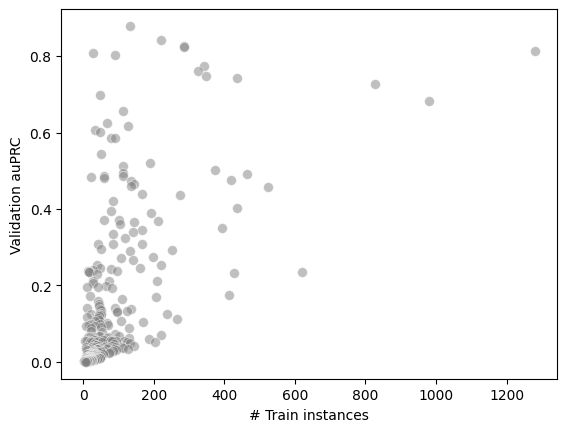

In [ ]:
fig = sns.scatterplot(
  x="train_n", y="auprc", data=overview_valid, alpha=0.5, s=50, color="grey"
)
fig.set_xlabel("# Train instances")
fig.set_ylabel("Validation auPRC");


This plot shows a clear trend: protein functions that occur more frequently in the training set tend to be predicted more accurately by the model on the validation set (as measured by auPRC). This aligns with expectations—machine learning models usually perform better on well-represented classes. It also highlights the challenge of class imbalance: rare functions are often poorly predicted, not necessarily due to biological complexity, but because the model has limited data to learn from.

But how do we know whether a specific auPRC score is actually *good*? An auPRC value of say 0.8 for a certain protein function might sound promising—but is that better than chance? Is it meaningful? To interpret these scores, we need something to compare them against.



### Evaluating Model Usefulness

To ground our evaluation, we’ll compare our model against two simple baselines:

- _Coin flip_: For each protein function, randomly predict 0 or 1 with equal probability. This gives us a baseline for total ignorance.
- _Proportional guessing_: Predict 1 for each function with probability equal to its frequency in the training set. This reflects prior class distribution knowledge, but without any learning.

These baselines help contextualize the model's performance. If our trained model doesn't outperform these simple heuristics, it's a sign that it may not have learned meaningful structure from the data.

Here are implementations for the baselines:

In [ ]:
def make_coin_flip_predictions(
  valid_true_df: pd.DataFrame, targets: list[str]
) -> pd.DataFrame:
  """Make random coin flip predictions for each protein function."""
  predictions = np.random.choice([0.0, 1.0], size=valid_true_df.shape)
  return pd.DataFrame(predictions, columns=targets, index=valid_true_df.index)


def make_proportional_predictions(
  valid_true_df: pd.DataFrame, train_df: pd.DataFrame, targets: list[str]
) -> pd.DataFrame:
  """Make random protein function predictions proportional to frequency."""
  percent_1_train = dict(train_df[targets].mean())
  proportional_preds = []
  for target_column in targets:
    prob_1 = percent_1_train[target_column]
    prob_0 = 1 - prob_1
    proportional_preds.append(
      np.random.choice([0.0, 1.0], size=len(valid_true_df), p=[prob_0, prob_1])
    )
  return pd.DataFrame(
    np.stack(proportional_preds).T, columns=targets, index=valid_true_df.index
  )

These baselines should give us simple but informative reference points. Let’s now apply these prediction methods, alongside our trained model:


In [ ]:
prediction_methods = {
  "coin_flip_baseline": make_coin_flip_predictions(valid_true_df, targets),
  "proportional_guess_baseline": make_proportional_predictions(
    valid_true_df, train_df, targets
  ),
  "model": valid_prob_df,
}

Now let’s evaluate the baselines in exactly the same way as our model—by computing per-protein metrics and averaging them:


In [ ]:
metrics_by_method = {}
for method, preds_df in prediction_methods.items():
  metrics_by_method[method] = pd.DataFrame(
    [
      compute_metrics(valid_true_df.iloc[i], preds_df.iloc[i])
      for i in range(len(valid_true_df))
    ]
  ).mean()

pd.DataFrame(metrics_by_method)

,coin_flip_baseline,proportional_guess_baseline,model
accuracy,0.500276,0.956772,0.978687
recall,0.496772,0.099938,0.147566
precision,0.022848,0.084711,0.459438
auprc,0.024614,0.040729,0.393988
auroc,0.498560,0.538613,0.865556



Our model clearly outperforms both baselines across all metrics—especially in precision, auPRC, and auROC. This is expected, as the trained model leverages actual sequence features to make more informed predictions. As noted earlier, accuracy is not a reliable metric in this setting, and even simple proportional guessing achieves a deceptively high accuracy due to class imbalance.

Most of the model's performance gains come from a large increase in precision, while the improvement in recall is more modest. This means the model is good at correctly identifying positive cases *when* it makes a prediction, but it tends to miss many true positives—it’s cautious and biased toward predicting “no function.”

This highlights a key trade-off: the model is conservative but accurate. Depending on your application, you may want to tune this behavior—for example, by lowering the decision threshold to improve recall, as discussed earlier.

Next, we’ll break down the model’s strengths and weaknesses by individual protein function and compare performance against both baselines. This allows us to see which specific functions the model predicts well—and where it struggles:

In [ ]:
auprc_by_function = {}

for method, preds_df in prediction_methods.items():
  metrics_by_function = {}

  for function in targets:
    metrics_by_function[function] = compute_metrics(
      valid_true_df[function], preds_df[function]
    )

  auprc_by_function[method] = (
    pd.DataFrame(metrics_by_function)
    .T.merge(go_term_descriptions, left_index=True, right_on="term")
    .set_index("term")
    .sort_values("auprc", ascending=False)
  )["auprc"].to_dict()

We can visualize the function-level auPRC scores as a bar plot to highlight which functional categories the model handles best:


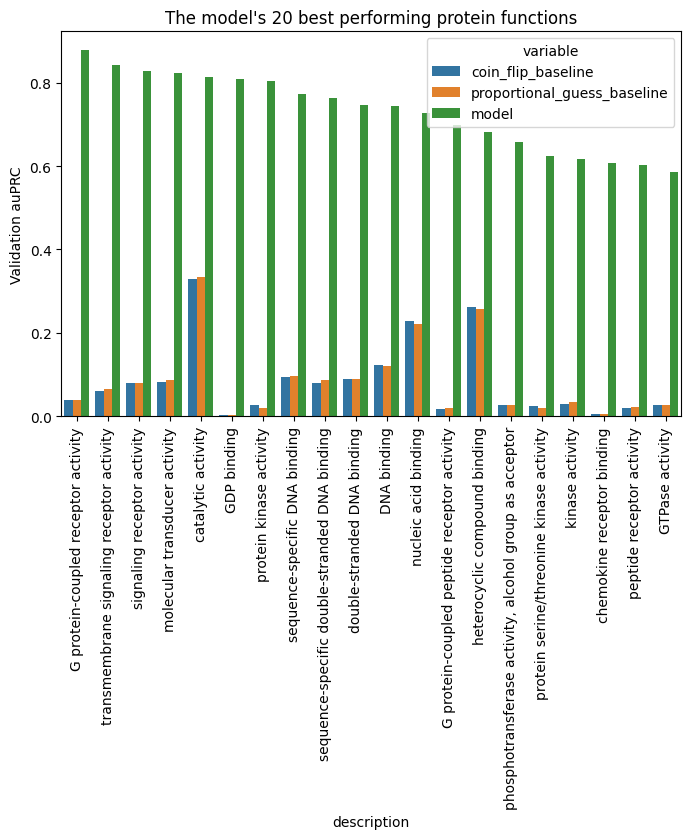

In [ ]:
best_performing = (
  pd.DataFrame(auprc_by_function)
  .merge(go_term_descriptions, left_index=True, right_on="term")
  .set_index("term")
  .sort_values("model", ascending=False)
  .head(20)
  .melt("description")
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
  x="description",
  y="value",
  hue="variable",
  data=best_performing,
)
ax.set_title("The model's 20 best performing protein functions")
ax.set_ylabel("Validation auPRC")
plt.xticks(rotation=90);


Many of the top-performing protein functions in the plot are related to membrane or signaling roles (e.g., GPCR activity, kinase activity, transmembrane receptor activity). One possible reason is that these functions often involve well-conserved sequence features—such as transmembrane helices or catalytic domains—that may be easier for models to learn. While speculative, this aligns with the idea that functions tied to strong structural or biochemical motifs may produce clearer sequence-level signals than more context-dependent roles.

Together, these results suggest that the model is capable of detecting meaningful biological signal for certain classes of protein function—and that it significantly outperforms simple baselines.




### Conducting a Final Check on the Test Set

Have a look at the next section for ideas on how to extend and improve this model. Once you're satisfied with your exploration, we can move on to the final step of this project: generating predictions on the test set.


```{warning}
Be sure not to touch the test set until you’ve fully finalized your model—including all hyperparameters, architectures, and training choices. Evaluating on the test set repeatedly can lead to overly optimistic results and undermine the validity of your findings.
```

We’ll make predictions on the test set proteins in the same way we did for the validation set:

In [ ]:
eval_metrics = []

for split in ["valid", "test"]:
  split_metrics = []

  for eval_batch in dataset_splits[split].batch(32).as_numpy_iterator():
    split_metrics.append(eval_step(state, eval_batch))

  eval_metrics.append(
    {"split": split, **pd.DataFrame(split_metrics).mean(axis=0).to_dict()}
  )
pd.DataFrame(eval_metrics)

,split,loss,accuracy,recall,precision,auprc,auroc
0,valid,0.080477,0.978739,0.144951,0.452929,0.390819,0.865123
1,test,0.082687,0.978015,0.145733,0.452534,0.397056,0.867356


The test set metrics closely mirror those observed on the validation set, which is good. In many workflows, test performance is slightly lower due to repeated use of the validation set during development—potentially leading to mild overfitting. However, in this case, we haven’t done extensive tuning, so the gap is minimal. Because the test set was held out throughout, its results provide a more reliable estimate of how the model will generalize to truly unseen data. These are the metrics we would report externally.



## Improvements and Extensions

The model we’ve built demonstrates that protein function can be predicted from sequence using pretrained embeddings and a lightweight classifier. However, many directions remain to improve, interpret, and extend this work. We split these ideas into two broad categories: analysis-driven insights and machine learning improvements.

But before diving into technical upgrades, it’s worth stepping back to revisit the bigger picture:

- _Why are you doing this?_ Who will use the model, and what do they actually need? Can you share this prototype with users now to gather early feedback?
- _When are you done?_ Is the current model already good enough? What specific improvements would meaningfully increase its utility? What benchmarks exist for this or similar tasks?
- _What matters most?_ Is performance across all functions equally important, or do you care about a specific class (e.g., enzymes vs. non-enzymes)? Focusing your optimization accordingly can save time.
- _Do you need interpretability?_ For some applications, understanding _why_ a model makes a prediction may matter more than maximizing performance.

Ideally, you’ll have thought about some of these questions before starting the modeling—but revisiting them now can help guide your next steps.



### Biological and Analytical Exploration

Even with a fixed model, we can learn a lot more by probing its behavior and comparing it to biological expectations:

- _Threshold tuning_: Our results showed that the model has high auPRC but low recall at a default probability threshold of 0.5. You could optimize this threshold (e.g., per protein function or globally) using a metric like F1 score to find a better trade-off between precision and recall.
- _Species generalization_: The current dataset is human-only, but this might be unnecessarily limited. Try including protein-function pairs from other species to see if performance improves.
- _Function-specific performance drivers_: Why does the model do well on some functions (e.g., GPCR activity) but poorly on others (e.g., growth factor activity)? You could investigate whether function prevalence, sequence length, or other properties correlate with performance.
- _Examine protein multifunctionality_: Does the model struggle more with proteins that have many functions? Group proteins by number of annotated functions and plot performance (e.g., auPRC) to see if there's a trend.
- _False positives that might be real_: Find proteins where the model confidently predicts a function that isn’t labeled. Could the model be correct and the annotation missing? How might you follow this up?



### Machine Learning Improvements

From a machine learning perspetive, here are a few directions you could explore:

- _Tune the MLP_: Our model is a small MLP on top of frozen embeddings. Try adding more layers, dropout, or batch normalization to increase capacity while controlling overfitting.
- _Alternative input encodings_: We used the mean-pooled embedding, which loses sequence order information. Try attention pooling or a small 1D CNN or transformer on top of the token-level embeddings.
- _Feature engineering_: You could augment the input to include protein length, species (if you extend beyond human), or even simple statistics like embedding norms. These additional features might help the model distinguish protein types more effectively.
- _Train a per-function head_: Instead of predicting all functions jointly, try training separate models (or heads) for each function. This can help when tasks are highly imbalanced or unrelated. Alternatively, you could cluster GO functions into a few categories and train a model per cluster.
- _Predict function hierarchically_: Rather than treating each function independently, you could use the GO hierarchy to add structure to predictions—e.g., predicting broad function categories first, then refining to more specific ones.
- _Try alternative base models_: You could plug in other protein language models from HuggingFace or explore combining embeddings from multiple models by concatenating them.
- _Unfreeze the language model_: The ESM2 embeddings are pretrained on a generic task. Fine-tuning the language model directly for protein function classification may boost performance, though it requires more compute and a more involved training setup.

```{tip}
While it’s tempting to chase performance gains through increasingly complex models, always align your efforts with the actual goals of your project. Improving interpretability or expanding biological coverage may be more valuable than inching up another point on a leaderboard.
```



## Summary

In this tutorial, we took a hands-on step into the world of deep learning for biology. Starting with a dataset of human proteins, we explored how to extract meaningful representations using a pretrained protein language model, trained a simple classifier to predict protein function, and evaluated its performance using quantitative metrics.

Along the way, we encountered practical challenges typical of biological modeling: getting comfortable with a new modeling setup, dealing with imbalanced label distributions, and carefully interpreting evaluation metrics.
